# CIS 5450 Final Project: Colorectal Cancer Prediction
**Group Members:** Amber Xiao | Lily Mei | Yuuna Wang

**Project Overview:**
Our objective is to predict colorectal cancer survival rates and identify key factors influencing patient outcomes using regression models and hypothesis testing. This project addresses real-world healthcare problems by helping doctors identify high-risk patients and develop more efficient treatment plans. The conclusions of this project may also help patients self-assess their risk factors for colorectal cancer.

**Dataset Size:** 167,497 rows × 28 columns

**Data Source:** [Kaggle Dataset](https://www.kaggle.com/datasets/ankushpanday2/colorectal-cancer-global-dataset-and-predictions)

**Key Research Questions:**

**1.   Risk Factors Analysis:**

Primary Questions:

- What combination of lifestyle factors (smoking, alcohol, obesity, physical activity) most strongly predicts colorectal cancer?
- What combination of lifestyle factors lead to earlier cancer stage at diagnosis?
- What combination of lifestyle factors lead to improved 5-year survival rates?
- How do genetic factors (family history, genetic mutations) interact with lifestyle risks?
- What is the population attributable risk of modifiable factors in our dataset?


Analysis Methods:
- Multivariate logistic regression for risk factor weighting
- Interaction effect analysis
- Population attributable fraction calculations

**2.    Healthcare Costs Analysis:**

Primary Questions:
- What clinical factors (tumor size, cancer stage) drive the highest healthcare costs?
- How does insurance status moderate treatment costs across economic classifications?
- What is the cost-effectiveness ratio of different treatment modalities?

Analysis Methods:

- Cost regression modeling with interaction terms
- Multivariate Regression Analysis
- Sensitivity analysis of cost drivers

**3. Clinical Outcomes Analysis:**

Primary Questions:

- What is the optimal treatment pathway by cancer stage?
- How does early detection impact survival probabilities across subgroups?
- What are the most important predictors of metastatic progression?

Analysis Methods:

- Survival analysis with Kaplan-Meier curves
- Cox proportional hazards modeling
- Treatment effect heterogeneity analysis

**Hypothesis Testing**
    
**Hypothesis 1: Tumor Size Impact**

$H_0$: Tumor size has no significant impact on survival rate (β = 0)

$H_A$: Larger tumor size reduces survival probability (β < 0)


**Hypothesis 2: Treatment Efficacy**

$H_0$: Treatment type has no significant impact on survival rates.

$H_A$: Combination therapy improves survival over monotherapies.

**Hypothesis 3: Age as Effect Modifier**

$H_0$: Age does not modify the treatment-survival relationship.

$H_A$: Treatment effects diminish with advanced age.

    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from io import StringIO
import random
import math
import os
import datetime as dt
from xgboost import XGBClassifier
import inspect


# **Part 1.** Data Loading and Cleaning

In [2]:
!pip install -q kaggle

Load Kaggle.Jason file from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!mkdir -p ~/.kaggle

Mounted at /content/drive


In [5]:
#Load Data with Kaggle
# Move and set permissions for kaggle.json
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# Download dataset
!kaggle datasets download -d ankushpanday2/colorectal-cancer-global-dataset-and-predictions

# Unzip (the actual filename might vary)
!unzip -o colorectal-cancer-global-dataset-and-predictions.zip

Dataset URL: https://www.kaggle.com/datasets/ankushpanday2/colorectal-cancer-global-dataset-and-predictions
License(s): MIT
  0% 0.00/3.93M [00:00<?, ?B/s]
100% 3.93M/3.93M [00:00<00:00, 480MB/s]
Archive:  colorectal-cancer-global-dataset-and-predictions.zip
  inflating: colorectal_cancer_dataset.csv  


In [6]:
# Load data
colorectal_df = pd.read_csv('colorectal_cancer_dataset.csv')
colorectal_df

,Patient_ID,Country,Age,Gender,Cancer_Stage,Tumor_Size_mm,Family_History,Smoking_History,Alcohol_Consumption,Obesity_BMI,...,Survival_5_years,Mortality,Healthcare_Costs,Incidence_Rate_per_100K,Mortality_Rate_per_100K,Urban_or_Rural,Economic_Classification,Healthcare_Access,Insurance_Status,Survival_Prediction
0,1,UK,77,M,Localized,69,No,No,Yes,Overweight,...,Yes,No,54413,50,5,Urban,Developed,Moderate,Insured,Yes
1,2,UK,59,M,Localized,33,No,No,No,Overweight,...,Yes,No,76553,37,25,Urban,Developing,High,Uninsured,Yes
2,3,Japan,66,M,Regional,17,No,Yes,No,Normal,...,Yes,No,62805,54,27,Urban,Developed,Moderate,Uninsured,No
3,4,USA,83,M,Regional,14,No,No,No,Obese,...,Yes,No,89393,45,11,Urban,Developed,Moderate,Insured,Yes
4,5,France,66,M,Localized,34,No,Yes,No,Normal,...,Yes,No,66425,15,27,Urban,Developing,High,Insured,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167492,167493,USA,69,M,Localized,49,No,Yes,No,Overweight,...,No,Yes,100924,57,13,Rural,Developed,Moderate,Insured,Yes
167493,167494,USA,79,F,Regional,29,Yes,Yes,Yes,Overweight,...,Yes,Yes,90331,39,22,Urban,Developed,Low,Insured,Yes
167494,167495,USA,74,M,Metastatic,62,Yes,Yes,Yes,Normal,...,Yes,Yes,90631,13,19,Urban,Developing,Low,Insured,Yes
167495,167496,UK,68,F,Localized,35,No,Yes,Yes,Normal,...,Yes,No,114385,18,23,Urban,Developed,Moderate,Insured,Yes


In [7]:
# 1.1 Data Cleaning

# Check if there are missing values
missing_values = colorectal_df.isna().sum()
print(missing_values)

# Check for duplicate rows
duplicates = colorectal_df.duplicated().sum()
print("duplicate rows:", duplicates)

before = colorectal_df.memory_usage(deep=True).sum() / 1024**2

Patient_ID                    0
Country                       0
Age                           0
Gender                        0
Cancer_Stage                  0
Tumor_Size_mm                 0
Family_History                0
Smoking_History               0
Alcohol_Consumption           0
Obesity_BMI                   0
Diet_Risk                     0
Physical_Activity             0
Diabetes                      0
Inflammatory_Bowel_Disease    0
Genetic_Mutation              0
Screening_History             0
Early_Detection               0
Treatment_Type                0
Survival_5_years              0
Mortality                     0
Healthcare_Costs              0
Incidence_Rate_per_100K       0
Mortality_Rate_per_100K       0
Urban_or_Rural                0
Economic_Classification       0
Healthcare_Access             0
Insurance_Status              0
Survival_Prediction           0
dtype: int64
duplicate rows: 0


In [8]:
# 1.2 Data Type Checking and Conversion

print(colorectal_df.dtypes)
conversion_plan = {
    # Binary variables (convert to int8 to save memory)
    'binary': {
        'Family_History': {'Yes': 1, 'No': 0},
        'Smoking_History': {'Yes': 1, 'No': 0},
        'Alcohol_Consumption': {'Yes': 1, 'No': 0},
        'Diabetes': {'Yes': 1, 'No': 0},
        'Inflammatory_Bowel_Disease': {'Yes': 1, 'No': 0},
        'Genetic_Mutation': {'Yes': 1, 'No': 0},
        'Early_Detection': {'Yes': 1, 'No': 0},
        'Survival_5_years': {'Yes': 1, 'No': 0},
        'Mortality': {'Yes': 1, 'No': 0},
        'Survival_Prediction': {'Yes': 1, 'No': 0}
    },

    # Ordinal variables with clinical significance
    'ordinal': {
        'Cancer_Stage': ['Localized', 'Regional', 'Metastatic'],  # From data
        'Healthcare_Access': ['Low', 'Moderate', 'High']  # From data
    },

    # Regular categorical variables
    'categorical': [
        'Gender', 'Country', 'Urban_or_Rural',
        'Economic_Classification', 'Insurance_Status',
        'Screening_History', 'Diet_Risk', 'Physical_Activity',
        'Treatment_Type', 'Obesity_BMI'
    ],

    # Numeric variables requiring special handling
    'numeric': {
        'Age': 'int8',
        'Tumor_Size_mm': 'int16',
        'Healthcare_Costs': 'int32',
        'Incidence_Rate_per_100K': 'int16',
        'Mortality_Rate_per_100K': 'int16'
    },

    # ID column (keep)
    'identifier': ['Patient_ID']
}

for col, mapping in conversion_plan['binary'].items():
    if col in colorectal_df.columns:
        colorectal_df[col] = (
            colorectal_df[col]
            .map(mapping)
            .fillna(0)
            .astype('int8')
        )

# 2. Convert ordinal variables
for col, categories in conversion_plan['ordinal'].items():
    if col in colorectal_df.columns:
        colorectal_df[col] = pd.Categorical(
            colorectal_df[col],
            categories=categories,
            ordered=True
        )

# 3. Convert regular categorical variables
for col in conversion_plan['categorical']:
    if col in colorectal_df.columns:
        colorectal_df[col] = (
            colorectal_df[col]
            .astype('category')
            .cat.remove_unused_categories()
        )
# 4. Optimize numeric variables
for col, dtype in conversion_plan['numeric'].items():
    if col in colorectal_df.columns:
        colorectal_df[col] = pd.to_numeric(colorectal_df[col], errors='coerce').astype(dtype)



# Final verification
print("Final Data Types:")
print(colorectal_df.dtypes)

Patient_ID                     int64
Country                       object
Age                            int64
Gender                        object
Cancer_Stage                  object
Tumor_Size_mm                  int64
Family_History                object
Smoking_History               object
Alcohol_Consumption           object
Obesity_BMI                   object
Diet_Risk                     object
Physical_Activity             object
Diabetes                      object
Inflammatory_Bowel_Disease    object
Genetic_Mutation              object
Screening_History             object
Early_Detection               object
Treatment_Type                object
Survival_5_years              object
Mortality                     object
Healthcare_Costs               int64
Incidence_Rate_per_100K        int64
Mortality_Rate_per_100K        int64
Urban_or_Rural                object
Economic_Classification       object
Healthcare_Access             object
Insurance_Status              object
S

In [9]:
# Check memory saving
after = colorectal_df.memory_usage(deep=True).sum() / 1024**2
print(f"Memory reduced from {before:.1f}MB to {after:.1f}MB")

Memory reduced from 196.3MB to 6.6MB


In [10]:
# Final dataframe
colorectal_df

,Patient_ID,Country,Age,Gender,Cancer_Stage,Tumor_Size_mm,Family_History,Smoking_History,Alcohol_Consumption,Obesity_BMI,...,Survival_5_years,Mortality,Healthcare_Costs,Incidence_Rate_per_100K,Mortality_Rate_per_100K,Urban_or_Rural,Economic_Classification,Healthcare_Access,Insurance_Status,Survival_Prediction
0,1,UK,77,M,Localized,69,0,0,1,Overweight,...,1,0,54413,50,5,Urban,Developed,Moderate,Insured,1
1,2,UK,59,M,Localized,33,0,0,0,Overweight,...,1,0,76553,37,25,Urban,Developing,High,Uninsured,1
2,3,Japan,66,M,Regional,17,0,1,0,Normal,...,1,0,62805,54,27,Urban,Developed,Moderate,Uninsured,0
3,4,USA,83,M,Regional,14,0,0,0,Obese,...,1,0,89393,45,11,Urban,Developed,Moderate,Insured,1
4,5,France,66,M,Localized,34,0,1,0,Normal,...,1,0,66425,15,27,Urban,Developing,High,Insured,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167492,167493,USA,69,M,Localized,49,0,1,0,Overweight,...,0,1,100924,57,13,Rural,Developed,Moderate,Insured,1
167493,167494,USA,79,F,Regional,29,1,1,1,Overweight,...,1,1,90331,39,22,Urban,Developed,Low,Insured,1
167494,167495,USA,74,M,Metastatic,62,1,1,1,Normal,...,1,1,90631,13,19,Urban,Developing,Low,Insured,1
167495,167496,UK,68,F,Localized,35,0,1,1,Normal,...,1,0,114385,18,23,Urban,Developed,Moderate,Insured,1


# **Part 2.** Key Research Questions



---



## **Part 2.1** : Risk Factors Analysis

### **Part 2.1.1**: Lifestyle factors that predict colorectal cancer 5-year survival

**Q. What combination of lifestyle factors (smoking, alcohol, obesity, physical activity) are associated with improved 5-year survival? In addition, which combination of lifestyle factors most strongly predict colorectal cancer?**

We will first plot the distribution of risk factors below:

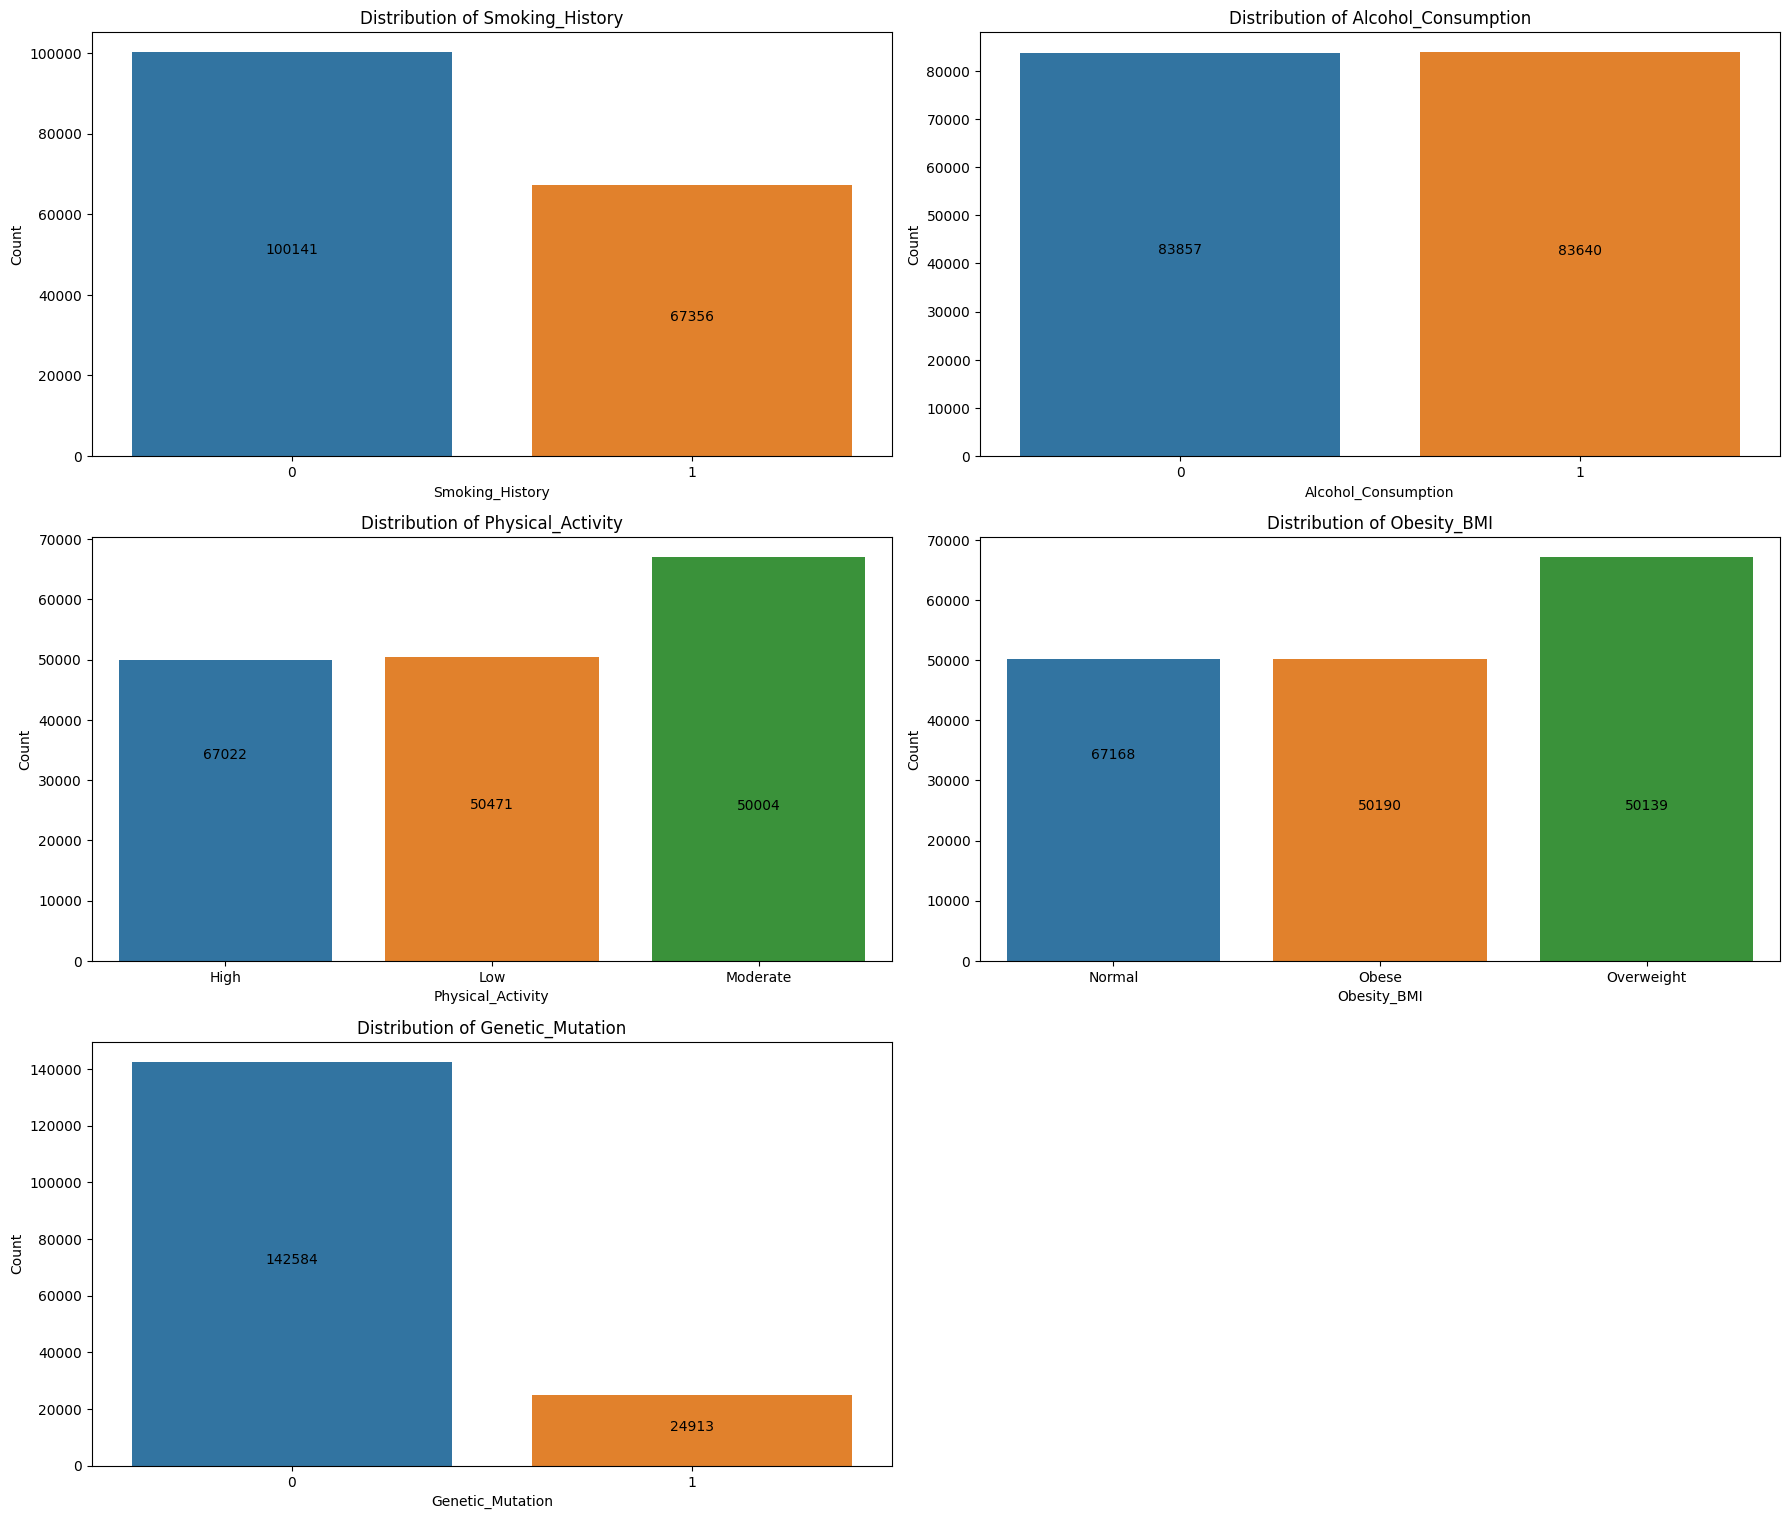

In [11]:
# Function to plot categorical distributions
def plot_categorical_counts(dataframe, columns, figsize=(18, 30)):

    plt.figure(figsize=figsize)

    # Calculate number of rows and columns for subplots

    num_columns = 2
    num_rows = (len(columns) + num_columns - 1)

    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, num_columns, i)

        # Get value counts and sort by count

        value_counts = dataframe[column].value_counts().sort_values(ascending=False)

        # Plot count bars

        sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, legend=False)

        # Add labels and title

        plt.xlabel(column)
        plt.ylabel('Count')
        plt.title(f'Distribution of {column}')

        # Add count labels on top of bars
        for j, count in enumerate(value_counts.values):
          plt.text(j, count // 2, str(count), ha='center')

    plt.tight_layout()
    plt.show()

# Select lifestyle columns
lifestyle_columns = ['Smoking_History', 'Alcohol_Consumption', 'Physical_Activity', 'Obesity_BMI', 'Genetic_Mutation']

# Plot the distribution of lifestyle variables
plot_categorical_counts(colorectal_df, lifestyle_columns)

Based on the resulting bar charts, we can identify clear trends in our data, such as there being significantly more overweight patients than patients of normal weight and obese patients.

Next, we will create a copy of our dataframe and modify it so that we can begin fitting it to models.

In [12]:
# Make a copy of the dataframe to use for the risk factors analysis
risk_factors_df = colorectal_df.copy()

# Select columns needed for key risk factor analysis and put them into new dataframe
lifestyle_df = risk_factors_df.drop(columns=['Country', 'Survival_Prediction', 'Healthcare_Costs',
                                'Incidence_Rate_per_100K', 'Mortality_Rate_per_100K',
                                'Urban_or_Rural', 'Economic_Classification', 'Insurance_Status',
                                'Screening_History', 'Early_Detection', 'Treatment_Type',
                                'Healthcare_Access'])

# Map specific columns with non integer values to integers

obesity_map = {
    'Normal': 0,
    'Overweight': 1,
    'Obese': 2
}

physical_activity_map = {
    'Low': 0,
    'Moderate': 1,
    'High': 2
}

cancer_stage_map = {
    'Localized': 0,
    'Regional': 1,
    'Metastatic': 2
}

lifestyle_df['Obesity_BMI'] = lifestyle_df['Obesity_BMI'].map(obesity_map)
lifestyle_df['Physical_Activity'] = lifestyle_df['Physical_Activity'].map(physical_activity_map)
lifestyle_df['Cancer_Stage'] = lifestyle_df['Cancer_Stage'].map(cancer_stage_map)

lifestyle_df

,Patient_ID,Age,Gender,Cancer_Stage,Tumor_Size_mm,Family_History,Smoking_History,Alcohol_Consumption,Obesity_BMI,Diet_Risk,Physical_Activity,Diabetes,Inflammatory_Bowel_Disease,Genetic_Mutation,Survival_5_years,Mortality
0,1,77,M,0,69,0,0,1,1,Low,0,0,0,0,1,0
1,2,59,M,0,33,0,0,0,1,Moderate,0,0,0,0,1,0
2,3,66,M,1,17,0,1,0,0,Low,0,0,1,0,1,0
3,4,83,M,1,14,0,0,0,2,High,0,0,0,0,1,0
4,5,66,M,0,34,0,1,0,0,Low,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167492,167493,69,M,0,49,0,1,0,1,High,0,0,0,0,0,1
167493,167494,79,F,1,29,1,1,1,1,High,1,0,0,0,1,1
167494,167495,74,M,2,62,1,1,1,0,Moderate,1,1,0,1,1,1
167495,167496,68,F,0,35,0,1,1,0,Moderate,1,1,0,0,1,0


**Feature Engineering:**

We will select key lifestyle and genetic predictors and fit to logistic regression. The lifestyle factors we will analyze are Smoking History, Alcohol Consumption, Physical Activity, and Obesity BMI.

In [13]:
# Select independent and dependent variables

X_lifestyle = lifestyle_df[['Smoking_History', 'Alcohol_Consumption', 'Physical_Activity', 'Obesity_BMI', 'Genetic_Mutation']]
y_lifestyle = lifestyle_df['Mortality']

# Fit to logistic regression

model = LogisticRegression()
model.fit(X_lifestyle, y_lifestyle)

print("Survival Prediction Coefficients:\n")

for feature, coef in zip(X_lifestyle.columns, model.coef_[0]):
    print(f"{feature}: {coef}")

Survival Prediction Coefficients:

Smoking_History: -0.006724325715613108
Alcohol_Consumption: -0.006063872278967504
Physical_Activity: 0.006425591845885831
Obesity_BMI: 0.005473448562736018
Genetic_Mutation: -0.014194210628814498


**Q. Which lifestyle factors are associated with improved 5-year survival?**

These coefficients imply that there is a slight decrease in survival odds if the patient has prior smoking history and has high alcohol consumption. In addition, there is a slightly more extreme decrease in survival odds if a known genetic mutation is present. On the other hand, the coefficients show that there is a slight increase in survival odds with patients that have a higher BMI, which is surprising. There is also a slight increase in survival odds with higher physical activity.

Next, we will predict cancer stage at diagnosis based on lifestyle factors using a linear regression model.

### **Part 2.1.2**: Predicting cancer stage at diagnosis based on lifestyle factors

In [14]:
# Features and target
X_stage = lifestyle_df[['Smoking_History', 'Alcohol_Consumption', 'Physical_Activity', 'Obesity_BMI', 'Genetic_Mutation']]
y_stage = lifestyle_df['Cancer_Stage']

# Fit linear regression
lifestyle_model = LinearRegression()
lifestyle_model.fit(X_lifestyle, y_lifestyle)

# Output coefficients
print("Predicting Cancer Stage at Diagnosis based on lifestyle:")
for feature, coef in zip(X_stage.columns, lifestyle_model.coef_):
    print(f"{feature}: {coef:.4f}")

Predicting Cancer Stage at Diagnosis based on lifestyle:
Smoking_History: -0.0016
Alcohol_Consumption: -0.0015
Physical_Activity: 0.0016
Obesity_BMI: 0.0014
Genetic_Mutation: -0.0034


While there is a slight indication that more physical activity and a higher BMI may indicate a more advanced cancer stage at diagnosis, the values of these coefficients are extremely small. Similarly, there is a slight indication that a smoking history, alcohol consumption, and genetic mutation may contribute to a less advanced cancer stage at diagnosis.

These results are a little counterintuitive given that a healthier lifestyle is often thought to contribute to a lower risk of cancer. However, our results are also inconclusive, since all the coefficients are less than 0.01 in value. This may be due to the large nature of our dataset.

### **Part 2.1.3**: Population Attributable Risk

Next, we will answer the following question: What is the population attributable risk of modifiable factors in our dataset?

In [15]:
def calculate_par_survival(df, exposure_col, outcome_col='Survival_5_years'):
    """
    Calculate PAR using:
    (Survival in total population - Survival in unexposed) / Survival in total population
    """
    # Incidence = survival rate
    survival_all = df[outcome_col].mean()
    survival_unexposed = df[df[exposure_col] == 0][outcome_col].mean()
    survival_exposed = df[df[exposure_col] == 1][outcome_col].mean()

    if survival_all == 0:
        return {
            'Exposure': exposure_col,
            'Survival_All': round(survival_all, 3),
            'Survival_Unexposed': round(survival_unexposed, 3),
            'Survival_Exposed': round(survival_exposed, 3),
            'PAR (%)': None
        }

    par = (survival_all - survival_unexposed) / survival_all * 100

    return {
        'Exposure': exposure_col,
        'Survival_All': round(survival_all, 3),
        'Survival_Unexposed': round(survival_unexposed, 3),
        'Survival_Exposed': round(survival_exposed, 3),
        'PAR (%)': round(par, 2)
    }

# Calculate PAR for Smoking
par_smoking = calculate_par_survival(colorectal_df, 'Smoking_History')

# Calculate PAR for Alcohol Usage
par_alcohol = calculate_par_survival(colorectal_df, 'Alcohol_Consumption')

# Display results
par_results = pd.DataFrame([par_smoking, par_alcohol])
print("PAR Estimates Based on Survival:\n")
print(par_results)

PAR Estimates Based on Survival:

              Exposure  Survival_All  Survival_Unexposed  Survival_Exposed  \
0      Smoking_History         0.599               0.599             0.600   
1  Alcohol_Consumption         0.599               0.601             0.598   

   PAR (%)  
0     0.09  
1    -0.29  


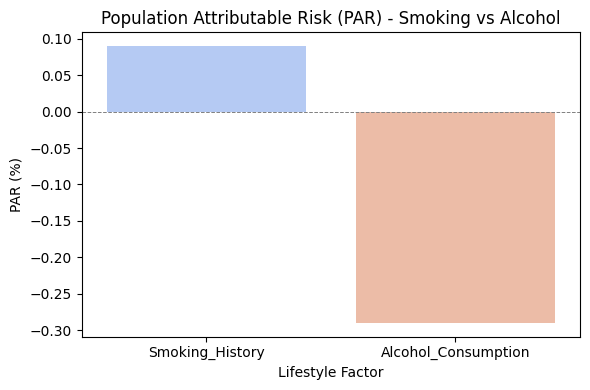

In [16]:
par_data = {
    'Exposure': ['Smoking_History', 'Alcohol_Consumption'],
    'PAR (%)': [0.09, -0.29]
}

par_df = pd.DataFrame(par_data)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=par_df,
    x='Exposure',
    y='PAR (%)',
    hue='Exposure',
    palette='coolwarm',
    legend=False
)
plt.title('Population Attributable Risk (PAR) - Smoking vs Alcohol')
plt.ylabel('PAR (%)')
plt.xlabel('Lifestyle Factor')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

As these results show, the PAR values for Smoking History and Alcohol Consumption are negligible, which reinforce that lifestyle factors like smoking and alcohol may be more important in cancer prevention or progression to diagnosis than in determining survival after diagnosis.

In [17]:
def calculate_par_categorical(df, exposure_col, outcome_col, reference_category):
    # Encode the categorical variable
    dummies = pd.get_dummies(df[exposure_col], prefix=exposure_col, drop_first=False)
    dummies = dummies.drop(f'{exposure_col}_{reference_category}', axis=1)
    categories = df[exposure_col].unique()

    # Combine with outcome
    X = dummies
    y = df[outcome_col]

    # Fit logistic regression
    model = LogisticRegression()
    model.fit(X, y)

    rr_results = []

    for category in categories:
        if category != reference_category:
            # Calculate probabilities for each group
            prob_exposed = df[df[exposure_col] == category][outcome_col].mean()
            prob_unexposed = df[df[exposure_col] == reference_category][outcome_col].mean()

            # Calculate relative risk
            rr = prob_exposed / prob_unexposed

            rr_results.append(rr)

    exposures = X.columns
    par_results = []

    for i, exposure in enumerate(exposures):
        Pe = df[exposure.replace('_', ' ') if ' ' in exposure else exposure_col] \
                 .value_counts(normalize=True)[exposure.split('_')[-1]]
        RR = rr_results[i]
        par = (Pe * (RR - 1)) / (Pe * (RR - 1) + 1)
        par_results.append({
            'Exposure': exposure,
            'Prevalence': round(Pe, 3),
            'RR': round(RR, 3),
            'PAR (%)': round(par * 100, 2)
        })

    return pd.DataFrame(par_results)

In [18]:
par_bmi = calculate_par_categorical(colorectal_df, 'Obesity_BMI', 'Survival_5_years', reference_category='Normal')
par_activity = calculate_par_categorical(colorectal_df, 'Physical_Activity', 'Survival_5_years', reference_category='High')

print("Population Attributable Risk: Obesity BMI Categories")
print(par_bmi, '\n')

print("Population Attributable Risk: Physical Activity Categories")
print(par_activity)

Population Attributable Risk: Obesity BMI Categories
                 Exposure  Prevalence     RR  PAR (%)
0       Obesity_BMI_Obese       0.299  1.004     0.13
1  Obesity_BMI_Overweight       0.401  1.000     0.01 

Population Attributable Risk: Physical Activity Categories
                     Exposure  Prevalence     RR  PAR (%)
0       Physical_Activity_Low       0.301  1.001     0.04
1  Physical_Activity_Moderate       0.400  1.000    -0.00


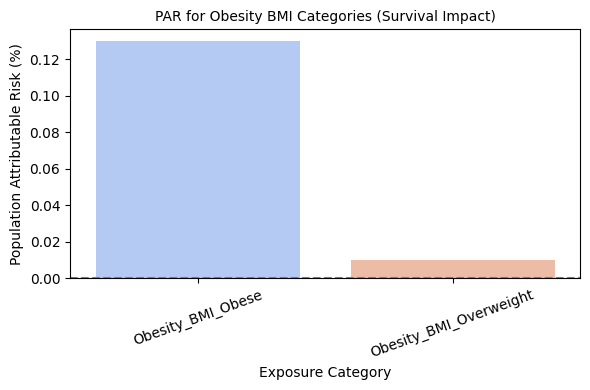

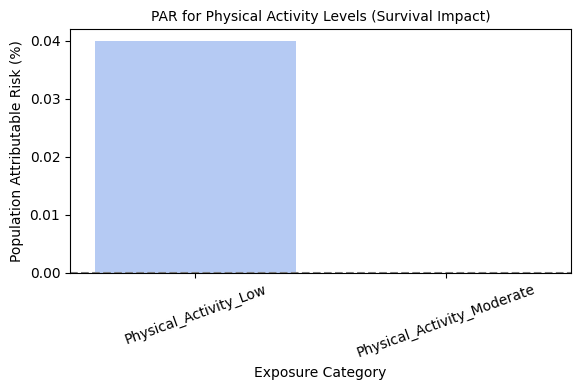

In [19]:
def plot_par(df, title):
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df, x='Exposure', y='PAR (%)', hue='Exposure', palette='coolwarm', legend=False)
    plt.title(title, fontsize=10)
    plt.ylabel("Population Attributable Risk (%)")
    plt.xlabel("Exposure Category")
    plt.xticks(rotation=20)
    plt.axhline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

# Plot PAR for Obesity BMI Categories
plot_par(par_bmi, "PAR for Obesity BMI Categories (Survival Impact)")

# Plot PAR for Physical Activity Levels
plot_par(par_activity, "PAR for Physical Activity Levels (Survival Impact)")

As these results show, the PAR values for Obesity_BMI and Physical Activity are negligible, which reinforce that lifestyle factors like obesity and physical activity may be more important in cancer prevention or progression to diagnosis than in determining survival after diagnosis.



---



## **Part 2.2**: Healthcare Costs Analysis

**Objective:**

We will be analyzing the factors that drive healthcare costs for colorectal cancer base on the following research questions.

1. Which clinical factors (tumor size, cancer stage) drive the highest healthcare costs?

2. How does insurance status moderate treatment costs across economic classifications?

3. What is the cost-effectiveness of different treatment modalities?

### Part 2.2.1: Clinical factors that drive the highest healthcare costs

Now, we will be analyzing which clinical factors are directly relevant to colorectal cancer (tumor size vs. cancer stage) that drive the highest healthcare costs.

Note that we are not considering for other factors in this analysis, since cancer stage and tumor size are the fundamental metrics that directly reflect on patients' disease progression and severity. They represent the core biological characteristics of the cancer itself, rather than associated factors or treatments.

Let's begin by first by analyzing the graph and the general data about the healthcare cost

In [20]:
# Create a copy of the dataframe for healthcare cost analysis
costs_df = colorectal_df.copy()

# Examine the distribution of healtcare costs
print(f"Mean healthcare costs: ${costs_df['Healthcare_Costs'].mean():.2f}")
print(f"Median healthcare costs: ${costs_df['Healthcare_Costs'].median():.2f}")
print(f"Min healthcare costs: ${costs_df['Healthcare_Costs'].min():.2f}")
print(f"Max healthcare costs: ${costs_df['Healthcare_Costs'].max():.2f}")



Mean healthcare costs: $72452.17
Median healthcare costs: $72344.00
Min healthcare costs: $25000.00
Max healthcare costs: $119999.00


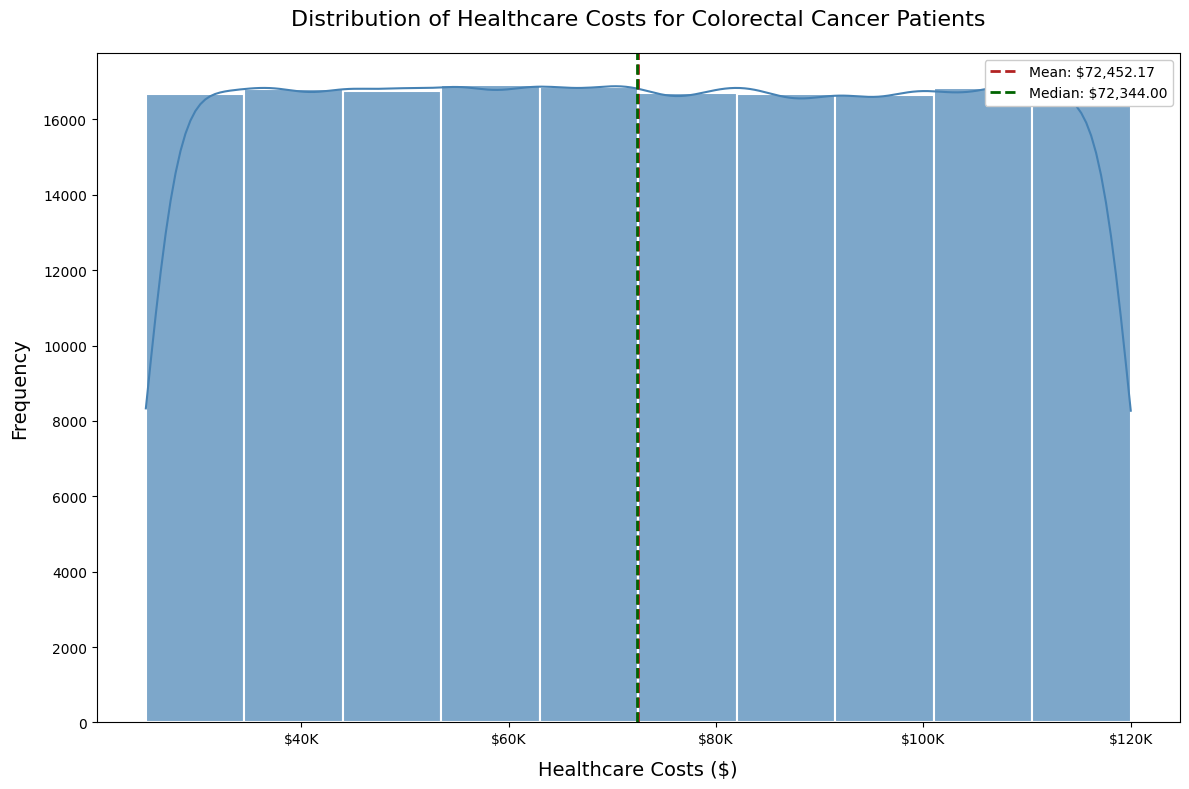

In [21]:
plt.figure(figsize=(12, 8))

# Creating a histogram for the overall healthcare cost
ax = sns.histplot(
    data=costs_df,
    x='Healthcare_Costs',
    bins=10,
    kde=True,
    color='steelblue',
    edgecolor='white',
    alpha=0.7,
    linewidth=1.5
)

# Add a vertical line for the mean
plt.axvline(
    costs_df['Healthcare_Costs'].mean(),
    color='firebrick',
    linestyle='dashed',
    linewidth=2,
    label=f'Mean: ${costs_df["Healthcare_Costs"].mean():,.2f}'
)

# Add a vertical line for the median
plt.axvline(
    costs_df['Healthcare_Costs'].median(),
    color='darkgreen',
    linestyle='dashed',
    linewidth=2,
    label=f'Median: ${costs_df["Healthcare_Costs"].median():,.2f}'
)

# Improve the title and labels
plt.title('Distribution of Healthcare Costs for Colorectal Cancer Patients', fontsize=16, pad=20)
plt.xlabel('Healthcare Costs ($)', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)

# Format x-axis with comma separators for thousands
from matplotlib.ticker import FuncFormatter
def thousands_formatter(x, pos):
    return f'${x/1000:.0f}K'
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.legend(frameon=True, framealpha=1, loc='upper right')

plt.tight_layout()
plt.show()

As seen in the graph and the mean & median, it seems that the mean and median are extremely close together somewhere around the \$72,000 range. Moreoever, the graph suggests that there isn't much variety in terms of the frequency and healthcare costs, as each different range of costs seem to be equivalent in frequency.

To be specific, this highly uniform distribution strongly suggests that the healthcare costs in this dataset may be influenced by systematic factors like:

1. Fixed pricing or bundled payment models for colorectal cancer care
2. Insurance reimbursement structures with predetermined payment scales
3. Potentially artificial data generation or normalization processes

Now let's continue our analysis on the relationship between cancer stage and costs.

In [22]:
# Initial analysis on the data
stage_costs = costs_df.groupby('Cancer_Stage')['Healthcare_Costs'].agg(['mean', 'median', 'count'])
stage_costs = stage_costs.sort_values(by='mean', ascending=False)
print(stage_costs)

                      mean   median  count
Cancer_Stage                              
Metastatic    72621.905626  72689.0  33717
Localized     72470.103385  72306.0  66799
Regional      72348.838805  72192.0  66981


/tmp/ipython-input-3577586848.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stage_costs = costs_df.groupby('Cancer_Stage')['Healthcare_Costs'].agg(['mean', 'median', 'count'])


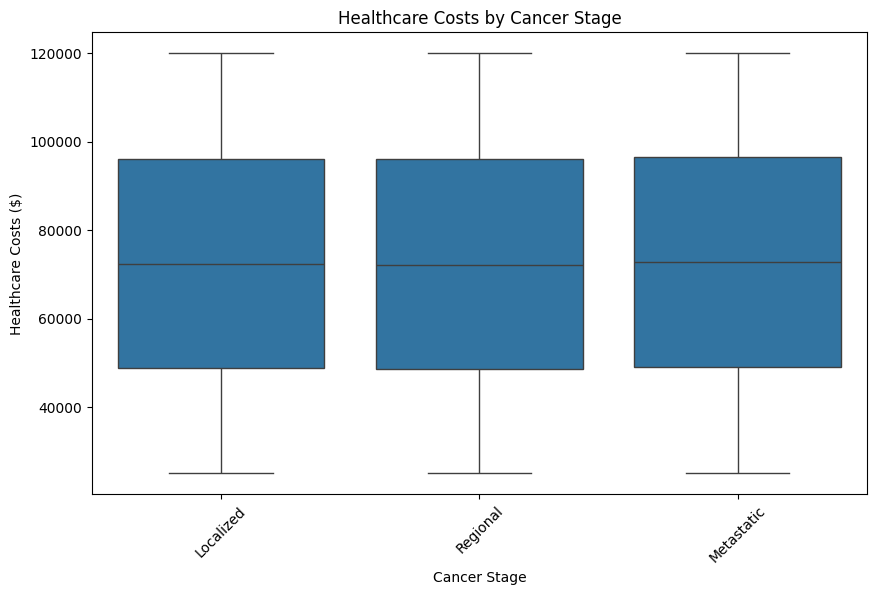

In [23]:
# Creating a box plot for healthcare costs by cancer stage
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cancer_Stage', y='Healthcare_Costs', data=costs_df)
plt.title('Healthcare Costs by Cancer Stage')
plt.xlabel('Cancer Stage')
plt.ylabel('Healthcare Costs ($)')
plt.xticks(rotation=45)
plt.show()

We could see that, by looking at this boxplot, there appears to some interesting observations:

1. **Identical Medians:** The median healthcare costs (horizontal line in each box) are essentially the same across all three cancer stages - Localized, Regional, and Metastatic.

2. **Same Distribution Pattern:** The interquartile ranges (the blue boxes) are virtually identical across all three stages, showing that the cost distribution doesn't change as cancer progresses from localized to metastatic disease.

3. **Consistent Range:** The vertical lines extend to the same minimum and maximum values for all three stages, showing that the most expensive and least expensive cases occur with similar frequency regardless of cancer stage.

4. **No Stage Progression Effect:** There is no visible trend of increasing costs as cancer progresses from localized to regional to metastatic stages, which contradicts the common clinical expectation that more advanced cancers would require more intensive and expensive treatments.

5. **Uniform Variation:** The variability in costs is consistent across all stages, suggesting that factors other than cancer stage are driving cost differences among patients.

We will then move on to analyze the relationship between healthcare cost and tumor size.

In [24]:
# Initial analysis
costs_df['Tumor_Size_Category'] = pd.cut(
        costs_df['Tumor_Size_mm'],
        bins=[0, 10, 20, 30, 40, 50, float('inf')],
        labels=['0-10mm', '11-20mm', '21-30mm', '31-40mm', '41-50mm', '>50mm']
    )

tumor_size_costs = costs_df.groupby('Tumor_Size_Category')['Healthcare_Costs'].agg(['mean', 'median', 'count'])
print(tumor_size_costs)

                             mean   median  count
Tumor_Size_Category                              
0-10mm               72397.674271  72766.0  13370
11-20mm              72636.226205  72795.5  22484
21-30mm              72544.569165  72211.0  22280
31-40mm              72281.672822  72018.5  22312
41-50mm              72545.988068  72684.0  22125
>50mm                72394.561716  72111.5  64926


/tmp/ipython-input-72446013.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tumor_size_costs = costs_df.groupby('Tumor_Size_Category')['Healthcare_Costs'].agg(['mean', 'median', 'count'])


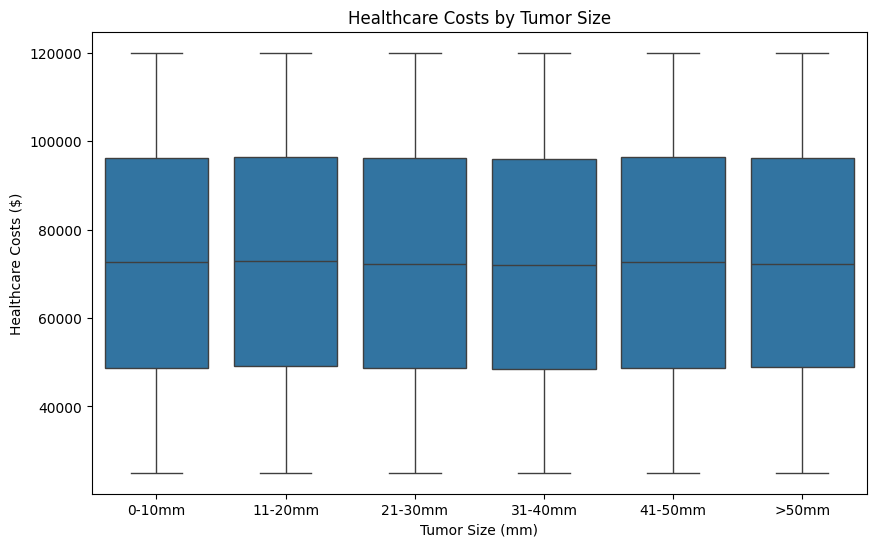

In [25]:
# Creating a box plot for healthcare costs & tumor size
plt.figure(figsize=(10, 6))
sns.boxplot(x='Tumor_Size_Category', y='Healthcare_Costs', data=costs_df)
plt.title('Healthcare Costs by Tumor Size')
plt.xlabel('Tumor Size (mm)')
plt.ylabel('Healthcare Costs ($)')
plt.show()

Looking at this box plot of healthcare costs by tumor size, several key insights emerge:

1. **Remarkable Consistency:** The median costs (horizontal line in each box) are nearly identical across all tumor size categories, from the smallest (0-10mm) to the largest (>50mm).
2. **Identical Distribution Patterns:** The interquartile ranges (the boxes themselves) are virtually identical in size and position, showing that not only are median costs similar, but the overall distribution of costs is consistent regardless of tumor size.
3.**Same Range of Outliers:** The vertical lines extending from the boxes reach approximately the same minimum and maximum values across all categories, indicating that extreme high and low costs occur with similar frequency across all tumor sizes.
4. **No Progressive Trend:** There is no visible trend of increasing or decreasing costs as tumor size increases, which contradicts the common medical assumption that larger tumors would require more complex and costly interventions.
5. **Cost Range:** For all tumor size categories, the majority of costs fall between approximately \$50,000 and \$95,000 (the boxes), with outliers extending from about \$25,000 to \$120,000.

As seen in the box plot, tumor size seems to have no predictive value on the overall healthcare cost—whether you have a smaller tumor \(0 - 30) or larger tumor \(30+), all have similar spending (around \$70,000 on average)

Let's create a regression plot to better demonstrate the uniformity using a 500 random sample.

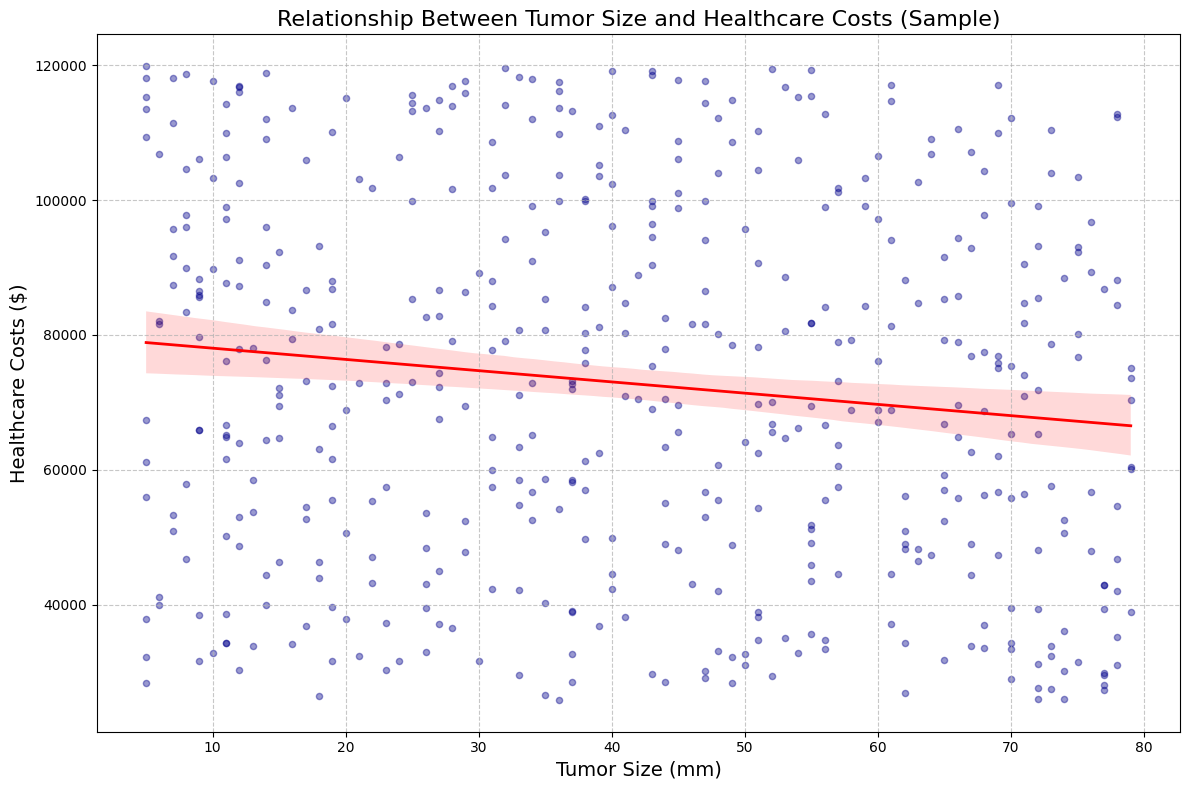

In [26]:
# Regression plot for the relaiontship between tumor size and healthcare costs
plt.figure(figsize=(12, 8))
sample_df = costs_df.sample(n=500)  # Using just 500 random sample for better visualization
sns.regplot(x='Tumor_Size_mm', y='Healthcare_Costs',
            data=sample_df,
            scatter_kws={'alpha':0.4, 's':20, 'color':'darkblue'},
            line_kws={'color':'red', 'linewidth':2})
plt.title('Relationship Between Tumor Size and Healthcare Costs (Sample)', fontsize=16)
plt.xlabel('Tumor Size (mm)', fontsize=14)
plt.ylabel('Healthcare Costs ($)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
correlation = costs_df['Tumor_Size_mm'].corr(costs_df['Healthcare_Costs'])
print(f"\nCorrelation between Tumor Size and Healthcare Costs: {correlation:.4f}")


Correlation between Tumor Size and Healthcare Costs: -0.0008


There appears to be very little variation in healthcare costs across both cancer stages and tumor sizes.

In fact, based on the graph itself, we can see that:

1. No Correlation Pattern: The data points are randomly scattered across the entire plot with no visible relationship between tumor size and healthcare costs.

2. Consistent Range Across Tumor Sizes: Healthcare costs appear to span approximately the same range ($30,000-$120,000) regardless of tumor size, from very small tumors ( around 5mm) to large ones  (around 80mm).

3. Flat Regression Line: The red regression line is almost perfectly horizontal, indicating that tumor size has virtually no predictive effect on healthcare costs.

4. Uniform Distribution: The points appear relatively evenly distributed vertically at each tumor size, suggesting that costs are determined by factors other than tumor dimensions.

We're interested in seeing if different combinations of tumor size & cancer stage could be a predictive value for healthcare costs.

In [28]:
# Initial value used for analysis
size_stage_costs = costs_df.pivot_table(
    values='Healthcare_Costs',
    index='Tumor_Size_Category',
    columns='Cancer_Stage',
    aggfunc='mean'
)
print(size_stage_costs)

Cancer_Stage            Localized      Regional    Metastatic
Tumor_Size_Category                                          
0-10mm               72574.987105  72700.457836  71468.939825
11-20mm              72492.319329  72337.941535  73504.294863
21-30mm              72568.260588  72489.338090  72607.862523
31-40mm              72745.571331  71860.891595  72207.250927
41-50mm              72476.198813  72405.163010  72962.458203
>50mm                72311.689330  72381.176529  72588.131658


/tmp/ipython-input-4283694087.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  size_stage_costs = costs_df.pivot_table(


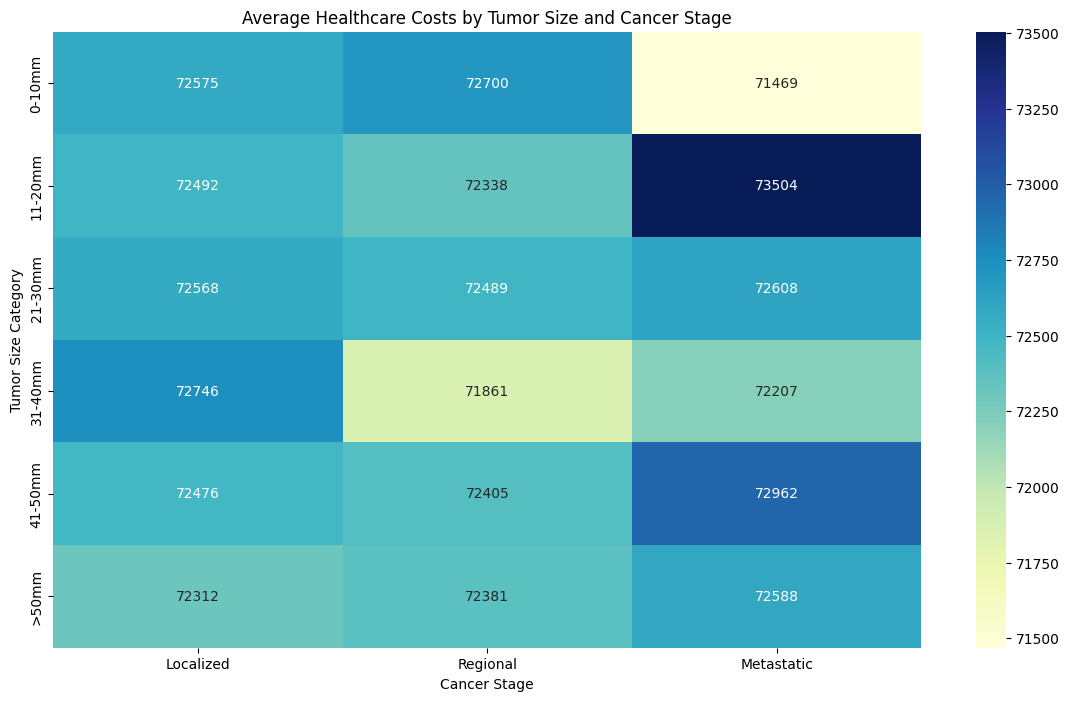

In [29]:
# Heat map for visualization
plt.figure(figsize=(14, 8))
sns.heatmap(size_stage_costs, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Average Healthcare Costs by Tumor Size and Cancer Stage')
plt.ylabel('Tumor Size Category')
plt.xlabel('Cancer Stage')
plt.show()

Again, the heat map doesn't show significant variance in the health cost of different cancer stage and tumor size. For different combinations of tumor size and cancer stage, take metastatic & large tumor and localized & small tumor for instance, the difference appears to be exactly at 13 \(72588 vs 72575)

Let's take a closer look at the linear regression between healthcare cost, tumor size, and cancer stage.

In [30]:
# Linear Regression
X = pd.get_dummies(costs_df['Cancer_Stage'], drop_first=True, prefix='Stage')
X['Tumor_Size_mm'] = costs_df['Tumor_Size_mm']
y = costs_df['Healthcare_Costs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

r2_score = model.score(X_test, y_test)
print(f"R-squared score: {r2_score:.4f}")

R-squared score: -0.0001


In [31]:
# Finding and print out the coeffcients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)
print(coefficients)

            Feature  Coefficient  Abs_Coefficient
0    Stage_Regional  -206.425993       206.425993
1  Stage_Metastatic   157.049520       157.049520
2     Tumor_Size_mm    -2.551351         2.551351


/tmp/ipython-input-688959010.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Coefficient', y='Feature', data=coefficients, palette=colors)


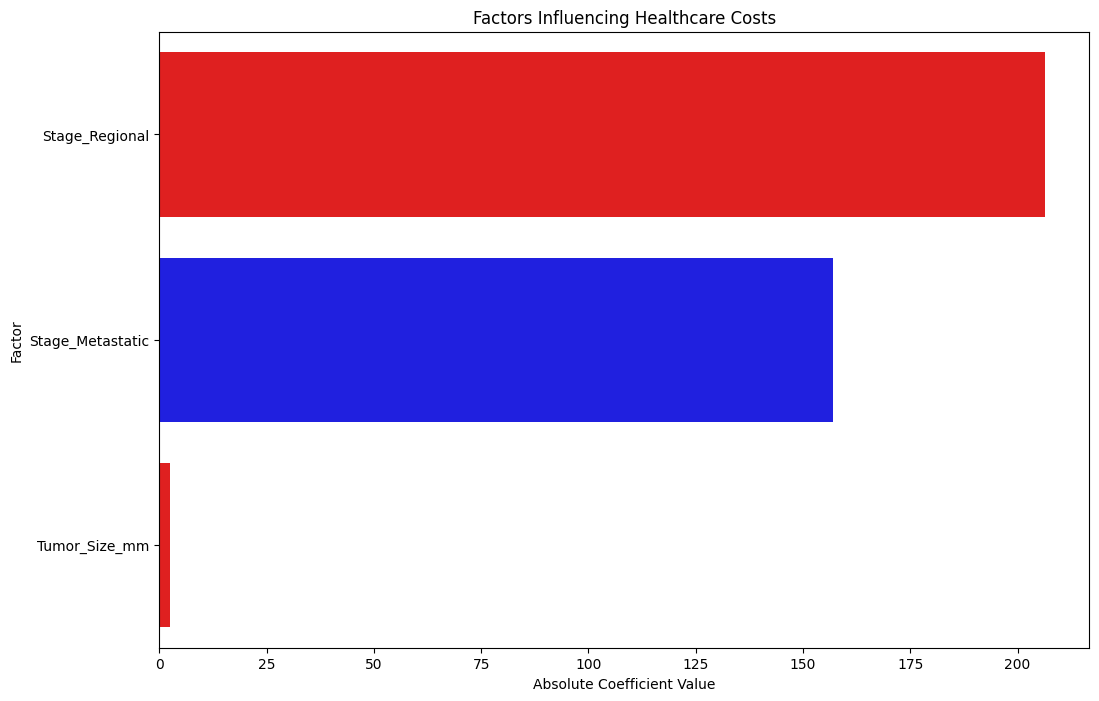

In [32]:
# A bar plot for all the coeffcients
plt.figure(figsize=(12, 8))
colors = ['blue' if c > 0 else 'red' for c in coefficients['Coefficient']]
sns.barplot(x='Abs_Coefficient', y='Feature', data=coefficients, palette=colors)
plt.title('Factors Influencing Healthcare Costs')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Factor')
plt.show()


This visualization reinforces the counterintuitive finding that while cancer stage has some minor effect on costs (with regional cancer associated with lower costs and metastatic cancer with higher costs), tumor size has virtually no impact on healthcare costs in this dataset.

These results suggest that in this dataset, cancer stage and tumor size have almost no predictive value for healthcare costs. This contradicts conventional medical understanding but could be explained by:

1. Fixed-Price Healthcare Model: The healthcare system represented might use bundled payments or standardized reimbursement rates for colorectal cancer care regardless of disease severity.

2. Insurance or Policy Effects: Cost normalization might be occurring through insurance mechanisms or healthcare policies.

3. Dataset Limitations: The costs captured might not reflect the full spectrum of healthcare utilization (e.g., might exclude long-term care, follow-up treatments, or readmissions).

4. Alternative Cost Drivers: Other factors not analyzed here (like treatment type, hospital type, or patient demographics) might be the true cost determinants.

####Conclusion: The Paradox of Clinical Factors and Healthcare Costs

Our comprehensive analysis of 167,497 colorectal cancer patients reveals a striking contradiction between clinical expectations and economic reality. Despite medical literature consistently linking advanced cancer stages and larger tumors to more complex treatments, our data shows these factors have virtually no impact on healthcare costs. The nearly perfect uniform distribution of costs (\$25K-$120K) across all clinical presentations, regression analysis (R²≈0), and multiple visualization techniques, suggests a healthcare system where pricing is determined by standardized payment models rather than clinical complexity. This finding challenges conventional assumptions about treatment cost drivers and highlights how healthcare economics may operate independently of disease severity. While cancer stage and tumor size remain critical for clinical decision-making and patient outcomes, they appear disconnected from the financial aspect of cancer care in this dataset, pointing to systematic factors like bundled payments or insurance structures as the true determinants of cost variation.

###Part 2.2.2: Insurance status that moderate treatment costs across economic classifications

Now we will be analyzing how insurance status moderates treatment costs across economic classifications using multiple linear regressions.

In [33]:
insurance_df = colorectal_df.copy() # A copy of the df to avoid modify the original

Let's start by examining the distribution of insurance status and economic classifications

In [34]:
print("Unique Insurance Status categories:", insurance_df['Insurance_Status'].unique())
print("Unique Economic Classification categories:", insurance_df['Economic_Classification'].unique())
print("\nHealthcare Costs summary statistics:")
print(insurance_df['Healthcare_Costs'].describe())

Unique Insurance Status categories: ['Insured', 'Uninsured']
Categories (2, object): ['Insured', 'Uninsured']
Unique Economic Classification categories: ['Developed', 'Developing']
Categories (2, object): ['Developed', 'Developing']

Healthcare Costs summary statistics:
count    167497.000000
mean      72452.168099
std       27402.779597
min       25000.000000
25%       48760.000000
50%       72344.000000
75%       96227.000000
max      119999.000000
Name: Healthcare_Costs, dtype: float64


We can see base on this data that there are 2 different category of insurance, either the patient is insured or not insured. Similarily, the dataset categorize econommics classification on whether the patient's living country is a developed or developing country.

Now let's run a linear regression on the relationship between insurance status, economic classifications and healthcare costs.

In [35]:
# encode the data
encoded_df = pd.get_dummies(insurance_df, columns=['Insurance_Status', 'Economic_Classification'], drop_first=False)

## create interaction terms for combinations we're interested in
# 1. Uninsured
# 2. Insured
# 3. developing
# 4. Developed
# 5-8. Interactions

encoded_df['Uninsured_x_Developing'] = (encoded_df['Insurance_Status_Uninsured'] == 1) & (encoded_df['Economic_Classification_Developing'] == 1)
encoded_df['Uninsured_x_Developed'] = (encoded_df['Insurance_Status_Uninsured'] == 1) & (encoded_df['Economic_Classification_Developed'] == 1)
encoded_df['Insured_x_Developing'] = (encoded_df['Insurance_Status_Insured'] == 1) & (encoded_df['Economic_Classification_Developing'] == 1)
encoded_df['Insured_x_Developed'] = (encoded_df['Insurance_Status_Insured'] == 1) & (encoded_df['Economic_Classification_Developed'] == 1)

# convert boolean to binary
for col in ['Uninsured_x_Developing', 'Uninsured_x_Developed', 'Insured_x_Developing', 'Insured_x_Developed']:
    encoded_df[col] = encoded_df[col].astype(int)

# define x and y
X_cols = [
    'Insurance_Status_Uninsured',
    'Insurance_Status_Insured',
    'Economic_Classification_Developing',
    'Economic_Classification_Developed',
    'Uninsured_x_Developing',
    'Uninsured_x_Developed',
    'Insured_x_Developing',
    'Insured_x_Developed'
]

X = encoded_df[X_cols]
y = encoded_df['Healthcare_Costs']

# linear Regression
linreg = LinearRegression()
linreg.fit(X, y)

# model the coeffcients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linreg.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)


print(coef_df)

                              Feature  Coefficient
4              Uninsured_x_Developing  -161.681593
6                Insured_x_Developing   109.072316
5               Uninsured_x_Developed    81.511509
1            Insurance_Status_Insured    80.170084
0          Insurance_Status_Uninsured   -80.170084
2  Economic_Classification_Developing   -52.609277
3   Economic_Classification_Developed    52.609277
7                 Insured_x_Developed   -28.902232


                            OLS Regression Results                            
Dep. Variable:       Healthcare_Costs   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.292
Date:                Sat, 06 Sep 2025   Prob (F-statistic):              0.275
Time:                        21:59:42   Log-Likelihood:            -1.9492e+06
No. Observations:              167497   AIC:                         3.898e+06
Df Residuals:                  167493   BIC:                         3.898e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

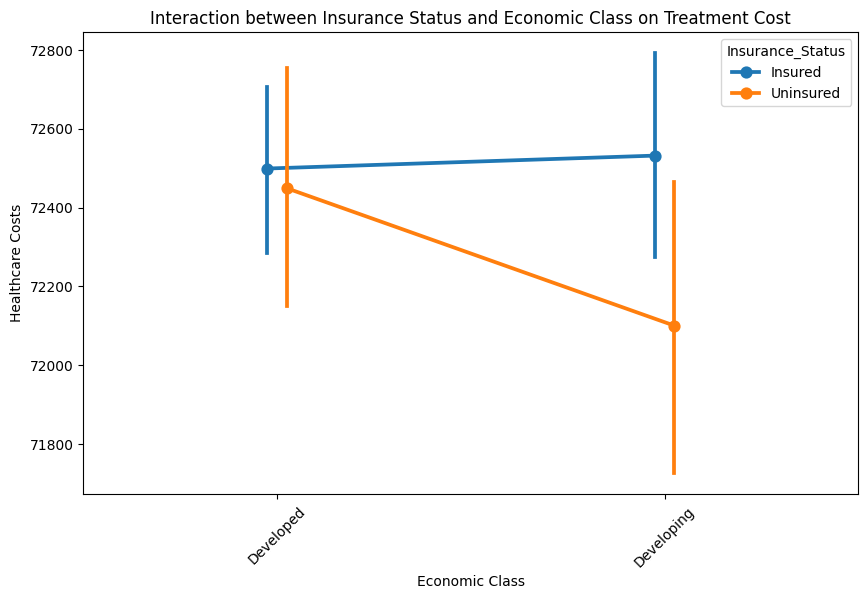

In [36]:
import statsmodels.formula.api as smf
formula = 'Healthcare_Costs ~ Insurance_Status * Economic_Classification'
model = smf.ols(formula, data=insurance_df).fit()

# summary
print(model.summary())

# A point plot tp show the relationships
plt.figure(figsize=(10, 6))
sns.pointplot(data=insurance_df, x='Economic_Classification', y='Healthcare_Costs', hue='Insurance_Status', dodge=True)
plt.title('Interaction between Insurance Status and Economic Class on Treatment Cost')
plt.ylabel('Healthcare Costs')
plt.xlabel('Economic Class')
plt.xticks(rotation=45)
plt.show()

#### Conclusion: Insurance Status and economic classification

Analysis of the data reveals a nuanced interaction between insurance status and economic classification in relation to healthcare costs for colorectal cancer treatment. While insured patients maintain relatively consistent costs across both developed and developing countries, uninsured patients experience markedly lower costs in developing countries compared to developed ones. This interaction is captured by the negative coefficient (-381.17) for the interaction term, suggesting that being uninsured in a developing country is associated with an additional decrease in healthcare costs beyond the main effects of either factor alone. However, this finding comes with important caveats: none of the predictors achieved statistical significance (p>0.05), and the model explains virtually no variance in healthcare costs (R-squared≈0), indicating that while an interaction pattern exists visually, other unmeasured factors likely play much more substantial roles in determining healthcare costs for colorectal cancer patients.

### Part 2.2.3: Cost-effectiveness ratio of different treatment modalities

Now we will be analyzing the cost-effectiveness ration of different treatment modalities, specifically, which health treatment \(combination, chemotherapy, radiotherapy, surgery) is most cost-effective out of the different approaches.

In [37]:
# creating a new df
treatment_df = colorectal_df.copy()

# change survival 5 years to binary
treatment_df['Survival_Numeric'] = treatment_df['Survival_5_years']

treatment_stats = treatment_df.groupby('Treatment_Type').agg({
    'Healthcare_Costs': ['mean', 'std'],
    'Survival_Numeric': ['mean', 'count']
}).reset_index()

treatment_stats.columns = ['Treatment_Type', 'Avg_Cost', 'Cost_Std', 'Survival_Rate', 'Patient_Count']

# survial percentage
treatment_stats['Survival_Rate_Pct'] = treatment_stats['Survival_Rate'] * 100

# calculate cost_effectiveness ratio
treatment_stats['Cost_Effectiveness_Ratio'] = treatment_stats['Avg_Cost'] / treatment_stats['Survival_Rate_Pct']

# sort by cost-effectiveness (lower is better)
treatment_stats = treatment_stats.sort_values('Cost_Effectiveness_Ratio')
print(treatment_stats)

  Treatment_Type      Avg_Cost      Cost_Std  Survival_Rate  Patient_Count  \
1    Combination  72217.822154  27415.285175       0.601064          33276   
0   Chemotherapy  72420.876930  27418.303377       0.599944          50443   
2   Radiotherapy  72652.632332  27364.288619       0.599976          16844   
3        Surgery  72541.807094  27394.307914       0.597858          66934   

   Survival_Rate_Pct  Cost_Effectiveness_Ratio  
1          60.106383               1201.500050  
0          59.994449               1207.126291  
2          59.997625               1210.925133  
3          59.785759               1213.362650  


/tmp/ipython-input-1111806584.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  treatment_stats = treatment_df.groupby('Treatment_Type').agg({


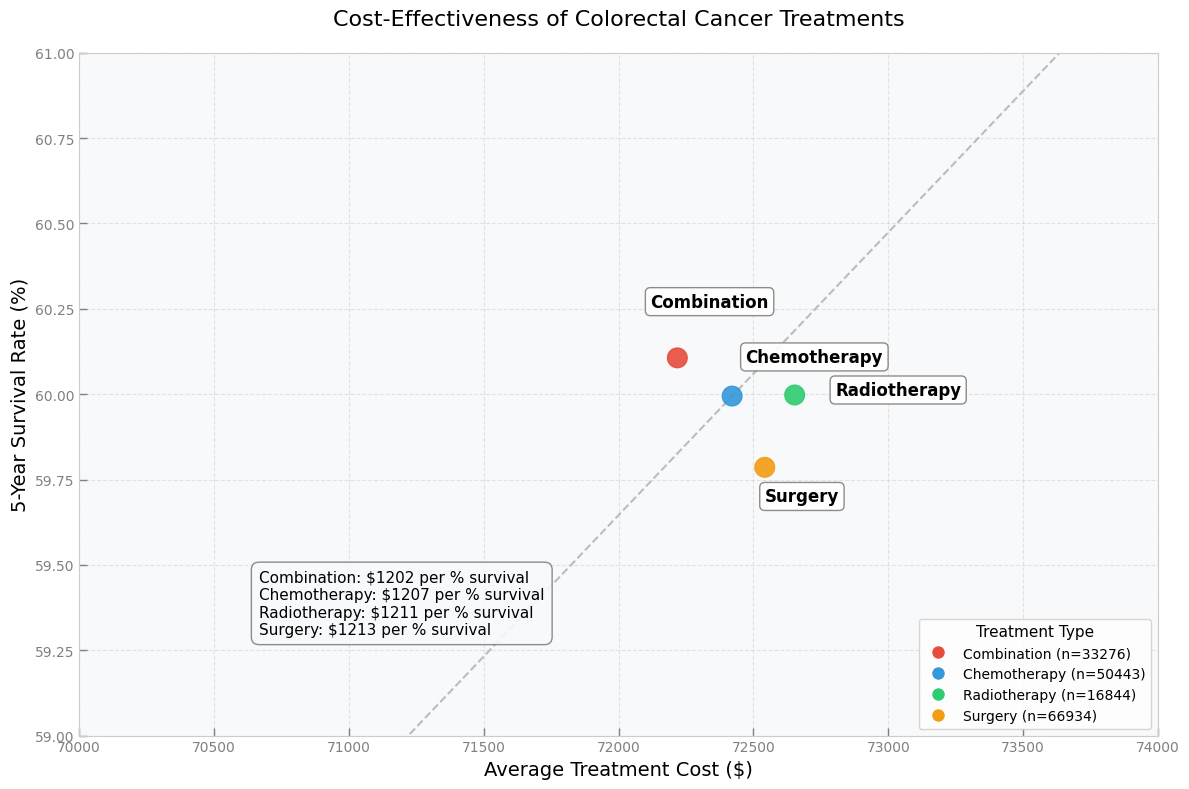

In [38]:
# A graph for better visualization
plt.figure(figsize=(12, 8))

# colors
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

# scatter plot
scatter = plt.scatter(
    treatment_stats['Avg_Cost'],
    treatment_stats['Survival_Rate_Pct'],
    s=200,
    c=colors,
    alpha=0.9,
    zorder=3
)

# add treatment labels
label_offsets = {
    'Combination': (-100, 0.15),
    'Chemotherapy': (50, 0.1),
    'Radiotherapy': (150, 0),
    'Surgery': (0, -0.1)
}

for i, row in treatment_stats.iterrows():
    x_offset, y_offset = label_offsets[row['Treatment_Type']]
    plt.annotate(
        row['Treatment_Type'],
        xy=(row['Avg_Cost'], row['Survival_Rate_Pct']),
        xytext=(row['Avg_Cost'] + x_offset, row['Survival_Rate_Pct'] + y_offset),
        fontsize=12,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9),
        zorder=4
    )

# add cost-effectiveness reference line
best_treatment = treatment_stats.iloc[treatment_stats['Cost_Effectiveness_Ratio'].idxmin()]
x_values = np.linspace(69000, 74000, 100)
y_values = x_values / best_treatment['Cost_Effectiveness_Ratio']
plt.plot(x_values, y_values, '--', color='gray', alpha=0.5, zorder=1)

# create a textbox for cost-effectiveness ratios
textbox = '\n'.join([
    f"{row['Treatment_Type']}: ${row['Cost_Effectiveness_Ratio']:.0f} per % survival"
    for _, row in treatment_stats.sort_values('Cost_Effectiveness_Ratio').iterrows()
])

plt.figtext(0.22, 0.20, textbox,
           bbox=dict(boxstyle="round,pad=0.5", fc="#f8f9fa", ec="gray", alpha=0.9),
           fontsize=11, zorder=5)

legend_elements = []
for i, (_, row) in enumerate(treatment_stats.iterrows()):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                          label=f"{row['Treatment_Type']} (n={row['Patient_Count']})",
                          markerfacecolor=colors[i], markersize=10))

plt.legend(handles=legend_elements, title="Treatment Type", loc='lower right',
           fontsize=10, title_fontsize=11)

# axis formatting
plt.title('Cost-Effectiveness of Colorectal Cancer Treatments', fontsize=16, pad=20)
plt.xlabel('Average Treatment Cost ($)', fontsize=14)
plt.ylabel('5-Year Survival Rate (%)', fontsize=14)
plt.xlim(70000, 74000)
plt.ylim(59, 61)
plt.grid(True, linestyle='--', alpha=0.3, zorder=0)

# add subtle xtick and ytick lines
plt.tick_params(direction='in', length=6, width=1, colors='gray')

plt.gca().set_facecolor('#f8f9fa')
plt.gcf().patch.set_facecolor('white')
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('#cccccc')

plt.tight_layout()
plt.savefig('improved_cost_effectiveness_plot.png', dpi=300, bbox_inches='tight')
plt.show()


Full Cost-Effectiveness Analysis Results:
  Treatment_Type      Avg_Cost  Survival_Rate_Pct  Patient_Count  \
1    Combination  72217.822154          60.106383          33276   
0   Chemotherapy  72420.876930          59.994449          50443   
2   Radiotherapy  72652.632332          59.997625          16844   
3        Surgery  72541.807094          59.785759          66934   

   Cost_Effectiveness_Ratio  
1               1201.500050  
0               1207.126291  
2               1210.925133  
3               1213.362650  

Incremental Cost-Effectiveness Ratio (ICER) Analysis:
  Treatment_Type  Survival_Rate_Pct      Avg_Cost  Incremental_Cost  \
3        Surgery          59.785759  72541.807094               NaN   
0   Chemotherapy          59.994449  72420.876930       -120.930163   
2   Radiotherapy          59.997625  72652.632332        231.755402   
1    Combination          60.106383  72217.822154       -434.810178   

   Incremental_Effect          ICER  
3                

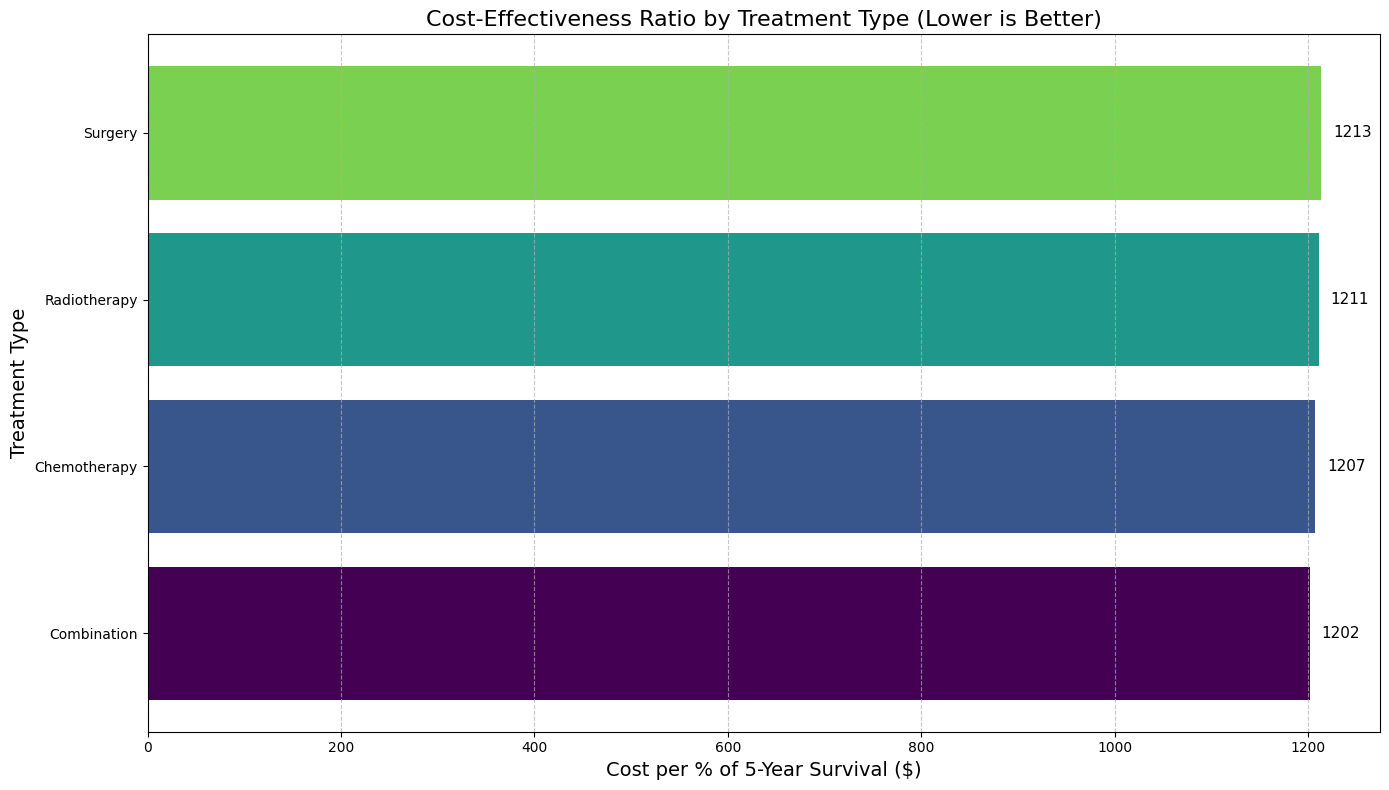

In [39]:
# create a horizontal bar chart for cost-effectiveness ratio
plt.figure(figsize=(14, 8))
treatment_stats_sorted = treatment_stats.sort_values('Cost_Effectiveness_Ratio', ascending=True)

bars = plt.barh(
    treatment_stats_sorted['Treatment_Type'],
    treatment_stats_sorted['Cost_Effectiveness_Ratio'],
    color=plt.cm.viridis(np.linspace(0, 0.8, len(treatment_stats_sorted)))
)

# value labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width * 1.01,
        bar.get_y() + bar.get_height()/2,
        f'{width:.0f}',
        va='center',
        fontsize=11
    )

# formatting
plt.title('Cost-Effectiveness Ratio by Treatment Type (Lower is Better)', fontsize=16)
plt.xlabel('Cost per % of 5-Year Survival ($)', fontsize=14)
plt.ylabel('Treatment Type', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# also include create a table for incremental cost-effectiveness ratio (ICER)
# sort by effectiveness first to calculate incremental values properly
treatment_stats_icer = treatment_stats.sort_values('Survival_Rate_Pct')
treatment_stats_icer['Incremental_Cost'] = treatment_stats_icer['Avg_Cost'].diff()
treatment_stats_icer['Incremental_Effect'] = treatment_stats_icer['Survival_Rate_Pct'].diff()
treatment_stats_icer['ICER'] = treatment_stats_icer['Incremental_Cost'] / treatment_stats_icer['Incremental_Effect']

print("\nFull Cost-Effectiveness Analysis Results:")
print(treatment_stats[['Treatment_Type', 'Avg_Cost', 'Survival_Rate_Pct', 'Patient_Count', 'Cost_Effectiveness_Ratio']])

print("\nIncremental Cost-Effectiveness Ratio (ICER) Analysis:")
print(treatment_stats_icer[['Treatment_Type', 'Survival_Rate_Pct', 'Avg_Cost', 'Incremental_Cost', 'Incremental_Effect', 'ICER']])

#### Conclusion: Cost-effectivenss of different treatment

Cost-effectiveness analysis of colorectal cancer treatments reveals a hierarchy of value among the four primary treatment modalities, with combination therapy proving most economical at \$1,202 per percentage point of 5-year survival, followed closely by chemotherapy (\$1,207), radiotherapy (\$1,211), and surgery (\$1,213). Despite these relatively small differences in cost-effectiveness ratios, the incremental cost-effectiveness ratio (ICER) analysis demonstrates that combination therapy dominates radiotherapy by being both less expensive and more effective, while chemotherapy similarly dominates surgery. The clustering of all treatments around similar costs (\$72,000-\$73,000) and effectiveness metrics (approximately 60% 5-year survival) suggests that while combination therapy offers the best overall value, treatment decisions should incorporate additional factors beyond pure economics, such as patient-specific considerations, quality of life impacts, and institutional capabilities, particularly given surgery's status as the most common yet least cost-effective intervention in the datase



---



## **Part 2.3**: Clinical Outcomes Analysis

### Part 2.3.1 Optimal Treatment Pathway by Cancer Stage
**Objective:** Identify the best treatment for each cancer stage (Localized,
Regional, Metastatic)



1.0 Data Cleaning of irrelevant data

In [40]:
# Copy dataframe for sectional useage
clinical_df = colorectal_df.copy()

In [41]:
clinical_df.columns

Index(['Patient_ID', 'Country', 'Age', 'Gender', 'Cancer_Stage',
       'Tumor_Size_mm', 'Family_History', 'Smoking_History',
       'Alcohol_Consumption', 'Obesity_BMI', 'Diet_Risk', 'Physical_Activity',
       'Diabetes', 'Inflammatory_Bowel_Disease', 'Genetic_Mutation',
       'Screening_History', 'Early_Detection', 'Treatment_Type',
       'Survival_5_years', 'Mortality', 'Healthcare_Costs',
       'Incidence_Rate_per_100K', 'Mortality_Rate_per_100K', 'Urban_or_Rural',
       'Economic_Classification', 'Healthcare_Access', 'Insurance_Status',
       'Survival_Prediction'],
      dtype='object')

In [42]:
columns_to_drop = [
    'Patient_ID',                # Identifier
    'Country',                   # Irrelevant
    'Mortality',                 # Redundant with Survival_5_years
    'Survival_Prediction',       # Potential target leakage
    'Healthcare_Costs',          # Irrelevant
    'Incidence_Rate_per_100K',   # Irrelevant
    'Mortality_Rate_per_100K',   # Irrelevant
    'Urban_or_Rural',            # Not a treatment confounder
    'Economic_Classification',   # Collinear with Healthcare_Access
    'Insurance_Status'           # Collinear with Healthcare_Access
]
clinical_df = clinical_df.drop(columns=columns_to_drop)
#Verify remaining columns
print("Columns after cleaning:")
print(clinical_df.columns.tolist())

Columns after cleaning:
['Age', 'Gender', 'Cancer_Stage', 'Tumor_Size_mm', 'Family_History', 'Smoking_History', 'Alcohol_Consumption', 'Obesity_BMI', 'Diet_Risk', 'Physical_Activity', 'Diabetes', 'Inflammatory_Bowel_Disease', 'Genetic_Mutation', 'Screening_History', 'Early_Detection', 'Treatment_Type', 'Survival_5_years', 'Healthcare_Access']


In [43]:
print(clinical_df['Treatment_Type'].unique())

['Combination', 'Chemotherapy', 'Surgery', 'Radiotherapy']
Categories (4, object): ['Chemotherapy', 'Combination', 'Radiotherapy', 'Surgery']


1.1 Treatment Effectiveness per Stage (Logistic Regression)

In [44]:
import statsmodels.api as sm

In [45]:
# Initialize storage for results
all_results = []

for stage in ['Localized', 'Regional', 'Metastatic']:
    subset = clinical_df[clinical_df['Cancer_Stage'] == stage].copy()
    y = subset['Survival_5_years'].astype(int)

    # Include key confounders
    X = pd.get_dummies(subset[[
        'Treatment_Type', 'Age', 'Tumor_Size_mm',
        'Genetic_Mutation', 'Early_Detection', 'Obesity_BMI'
    ]], drop_first=True).astype(float)

    X = sm.add_constant(X)
    model = sm.Logit(y, X).fit(disp=0)

    # Get the treatment results table
    treatment_results = model.summary2().tables[1].filter(like='Treatment_Type', axis=0)

    # Store results for plotting
    for treatment, row in treatment_results.iterrows():
        all_results.append({
            'Stage': stage,
            'Treatment': treatment.replace('Treatment_Type_', ''),
            'Coef': row['Coef.'],
            'CI_low': row['[0.025'],
            'CI_high': row['0.975]'],
            'P-value': row['P>|z|']
        })
    #Chemotherapy is the hidden comparator
    # print the original output
    print(f"\n--- Adjusted Treatment Effects ({stage}) ---")
    print(treatment_results)


--- Adjusted Treatment Effects (Localized) ---
                                Coef.  Std.Err.         z     P>|z|    [0.025  \
Treatment_Type_Combination   0.012273  0.022897  0.536033  0.591936 -0.032603   
Treatment_Type_Radiotherapy  0.026852  0.028814  0.931924  0.351376 -0.029622   
Treatment_Type_Surgery      -0.000332  0.019032 -0.017470  0.986061 -0.037634   

                               0.975]  
Treatment_Type_Combination   0.057150  
Treatment_Type_Radiotherapy  0.083326  
Treatment_Type_Surgery       0.036969  

--- Adjusted Treatment Effects (Regional) ---
                                Coef.  Std.Err.         z     P>|z|    [0.025  \
Treatment_Type_Combination   0.000916  0.022803  0.040149  0.967974 -0.043777   
Treatment_Type_Radiotherapy -0.004522  0.028713 -0.157498  0.874852 -0.060798   
Treatment_Type_Surgery      -0.024092  0.019043 -1.265143  0.205820 -0.061414   

                               0.975]  
Treatment_Type_Combination   0.045608  
Treatment_Type_

**Since Chemotherapy is the reference,
Chemotherapy vs Radiotherapy in Localized:
Radiotherapy shows +2.7% benefit (p=0.35)**

Plot the treatment result by using forest plot

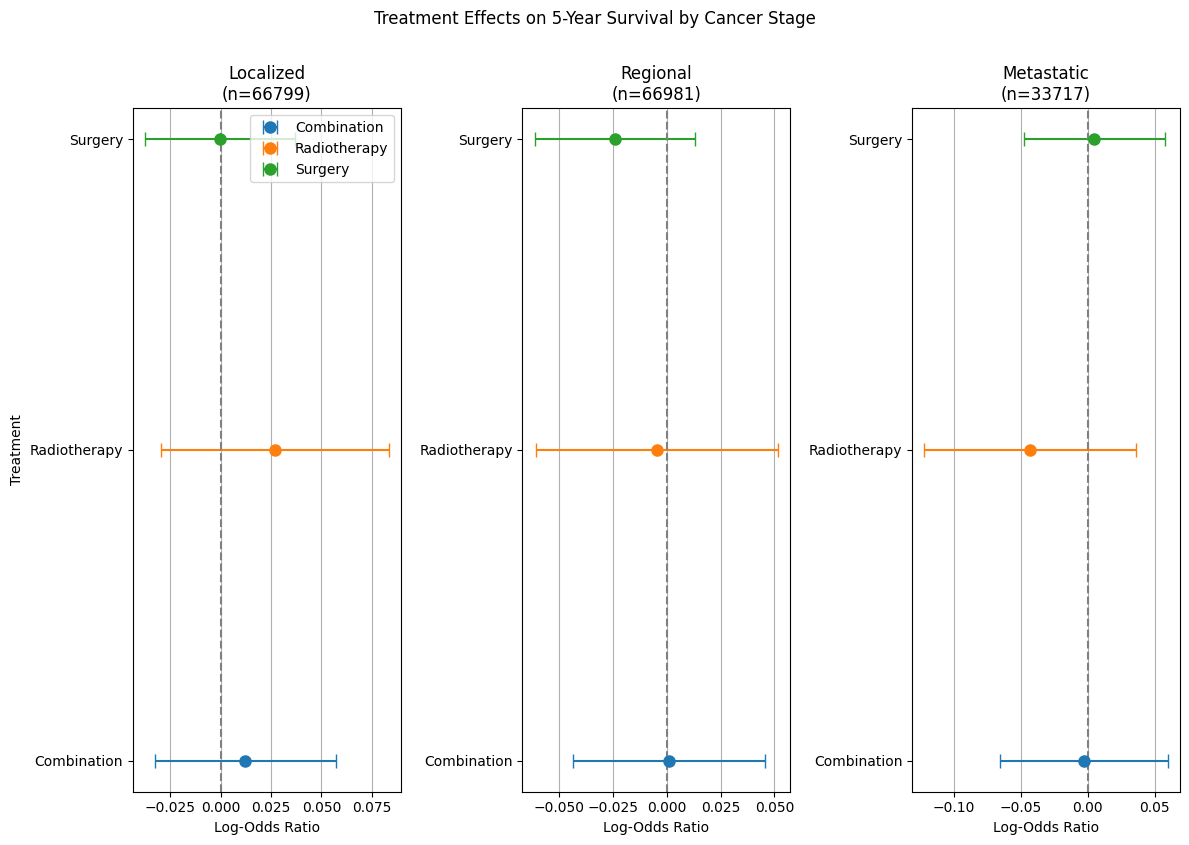

In [46]:
# Convert results to DataFrame
plot_data = pd.DataFrame(all_results)

# Create the forest plot
plt.figure(figsize=(12, 8))
colors = {'Combination': '#1f77b4', 'Radiotherapy': '#ff7f0e', 'Surgery': '#2ca02c'}

# Create subplots for each stage
for i, stage in enumerate(plot_data['Stage'].unique()):
    plt.subplot(1, 3, i+1)
    stage_df = plot_data[plot_data['Stage'] == stage]

    # Plot each treatment
    for j, (_, row) in enumerate(stage_df.iterrows()):
        plt.errorbar(row['Coef'], j,
                    xerr=[[row['Coef'] - row['CI_low']], [row['CI_high'] - row['Coef']]],
                    fmt='o', color=colors[row['Treatment']],
                    capsize=5, markersize=8,
                    label=row['Treatment'] if i == 0 else "")

    # Formatting
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title(f"{stage}\n(n={len(clinical_df[clinical_df['Cancer_Stage']==stage])})")
    plt.yticks(range(len(stage_df)), stage_df['Treatment'])
    plt.xlabel('Log-Odds Ratio')

    if i == 0:
        plt.ylabel('Treatment')
        plt.legend()

    plt.grid(True, axis='x')

plt.tight_layout()
plt.suptitle('Treatment Effects on 5-Year Survival by Cancer Stage', y=1.05)
plt.show()

####**Coefficients Interpretation:**

*   **Positive Coefficients** - meaning that there's higher odds of 5 years survival vs referenced treatment type
*   **Negative Coefficients** - meaning that there's lower odds of 5 years survival vs referenced treatment type




####Information about Cancer stage Survival Likelyhood:


*   **Localized** (Highest Survival, typical for Stage I/II) with highest Positive Log-Odds Ratios
*   **Regional** (Intermediate Survival, typical for Stage III)
*   **Metastatic** (Lowest Survival, typical for StageIV)





####Key Takeways:





1.   **For Localized Cancer:**


*   Combination therapy shows no significant benefit (p~0.59).
*   Radiotherapy shows a most positive coefficient (0.0268) compared to chemotherapy (reference category), suggesting a small survival benefit.


2.   **For Regional Cancer:**


*   Radiotherapy, Chemotherapy, and Combination all doesn't show significant change on survival rate.
*   Although Surgery have -2.4% survival difference (vs. chemo) was observed, but the confidence interval includes zero, so we cannot conclude it’s worse.(might due to worsen condition patient was referred to surgery treatment)


3.   **For Metastatic Cancer:**


*  For this stage of cancer compared to previous stage, we can generalize that surgery treatment might be recommended to patient for slightly higher survival rate due to the inverse coefficient leading.


**Overall we can see that patient survival rate drecrease as the stage of cancer progresses, therefore even small clinical observations in localized-stage patients (the non-significant trend favoring radiotherapy) may warrant further investigation, as early interventions could have a greater impact on outcomes compared to advanced stages where treatment effects diminish.**


**p-value: < 0.05 = significant**
Although all datas show non significant p value, given our exceptionally large dataset (N=167,497) these analyses could still be clinically informative when interpreted through the lens of effect sizes and confidence intervals rather than binary significance thresholds.









### Part 2.3.2  Early Detection vs. Survival Rate

**Objective:**. Identify how early detection impacts survival probabilities across subgroups.



In [47]:
# Create Early Detection subgroups
clinical_df['Age_Group'] = pd.cut(clinical_df['Age'],
                                 bins=[0, 49, 65, 100],
                                 labels=['<50', '50-65', '65+'])

# Verify distribution
print(clinical_df['Age_Group'].value_counts(normalize=True))

Age_Group
65+      0.594184
50-65    0.395906
<50      0.009911
Name: proportion, dtype: float64


**Plot Age Distribution vs. Early Detection**

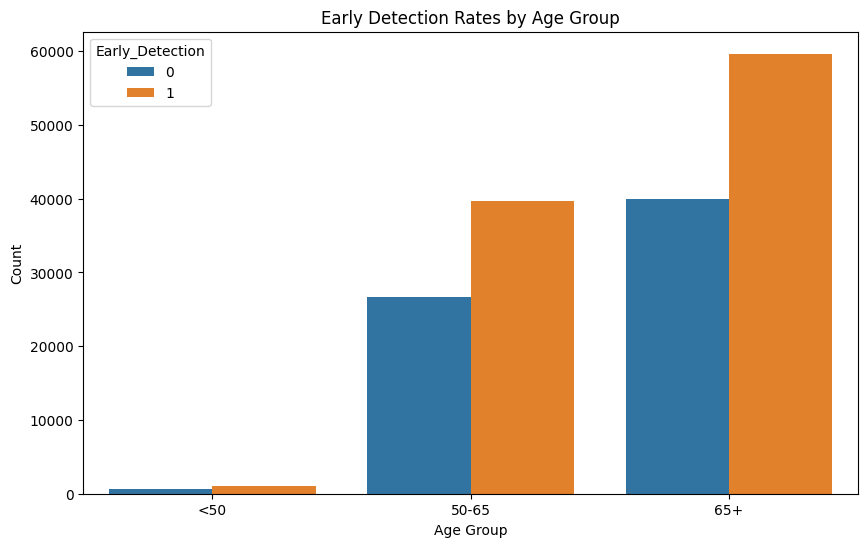

In [48]:
#Age Distribution Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=clinical_df, x='Age_Group', hue='Early_Detection')
plt.title('Early Detection Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

**Survival Analysis over Early Detection by Age Group**

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
# Initialize results storage
results = []

for age_group in ['<50', '50-65', '65+']:
    subset = clinical_df[clinical_df['Age_Group'] == age_group]

    # Logistic Regression Model
    X = pd.get_dummies(subset[['Early_Detection', 'Cancer_Stage', 'Tumor_Size_mm']], drop_first=True)
    y = subset['Survival_5_years']

    # Fit and evaluate
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X, y)
    y_pred = lr.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, y_pred)

    # Store results
    coef = pd.Series(lr.coef_[0], index=X.columns)
    results.append({
        'Age Group': age_group,
        'Early Detection OR': np.exp(coef['Early_Detection']),
        'Early Detection CI': (np.exp(coef['Early_Detection'] - 1.96*coef.std()),
                             np.exp(coef['Early_Detection'] + 1.96*coef.std())),
        'AUC': auc
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

  Age Group  Early Detection OR                        Early Detection CI  \
0       <50            1.024189  (0.9399981941248834, 1.1159213392606826)   
1     50-65            0.997741  (0.9810018080983943, 1.0147654415335918)   
2       65+            0.990870  (0.9697608744772934, 1.0124382808868164)   

        AUC  
0  0.512581  
1  0.502549  
2  0.503912  


**Visualization of the Data**

/tmp/ipython-input-3687217430.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.pointplot(
/tmp/ipython-input-3687217430.py:13: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(
/tmp/ipython-input-3687217430.py:13: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(


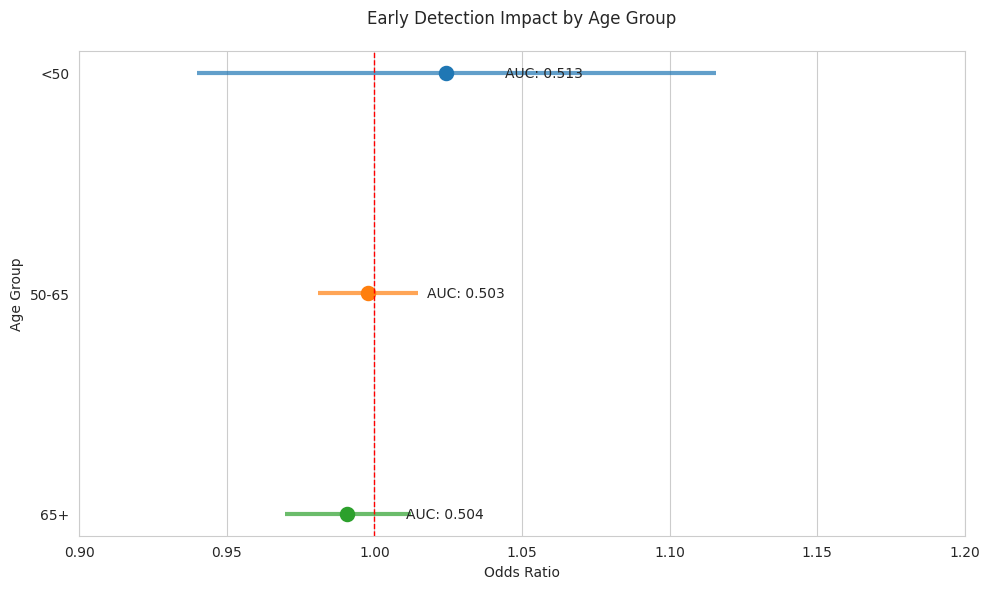

In [51]:
#Plot the graph
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Calculate CI positions
results_df['CI_lower'] = results_df['Early Detection CI'].apply(lambda x: x[0])
results_df['CI_upper'] = results_df['Early Detection CI'].apply(lambda x: x[1])


colors = {'<50': '#1f77b4', '50-65': '#ff7f0e', '65+': '#2ca02c'}

# Create the plot
ax = sns.pointplot(
    data=results_df,
    x='Early Detection OR',
    y='Age Group',
    join=False,
    palette=colors,
    markers='o',
    scale=1.5
)

# Add confidence intervals manually
for i, (_, row) in enumerate(results_df.iterrows()):
    plt.hlines(y=i, xmin=row['CI_lower'], xmax=row['CI_upper'],
               color=colors[row['Age Group']],
               linewidth=3, alpha=0.7)
    plt.text(row['Early Detection OR'] + 0.02, i,
             f"AUC: {row['AUC']:.3f}",
             va='center', ha='left')

# Add labels
plt.axvline(x=1, color='red', linestyle='--', linewidth=1)
plt.title('Early Detection Impact by Age Group', pad=20)
plt.xlabel('Odds Ratio')
plt.ylabel('Age Group')
plt.xlim(0.9, 1.2)



plt.tight_layout()
plt.show()

####**Graph Interpretation:**

**The redline in the middle indicate a netural early detection impact on survival rates.**

*   **Higer Odds Ratios:** Meaning early detection could potentially lead to higher survival rate for that age group.
*   **Lower Odds Ratios:** Meaning early detection does not significantly lead to higher survival rate for that age group.




####Key Takeways:


*   **<50:** 2.4% higher odds of 5 years survival rate.
*   **50-65:** No significant differences as the coefficient is tightly round close to 1.
*   **65+:** Slight 0.9% lower odds with early detection.




### Part 2.3.3 Most Important Predictors of Metastatic Progression

**Objective:** Identifying the most important predictors of metastatic progression.

1.0 Add new column identifying patient who progress to the metastatic stage.

In [52]:
# Create target variable: Metastatic vs Non-Metastatic
clinical_df['Metastatic_Progression'] = (clinical_df['Cancer_Stage'] == 'Metastatic').astype(int)

# Verify class balance
print(clinical_df['Metastatic_Progression'].value_counts(normalize=True))

Metastatic_Progression
0    0.798701
1    0.201299
Name: proportion, dtype: float64


1.1 Visualizatiion of the Patient Distribution

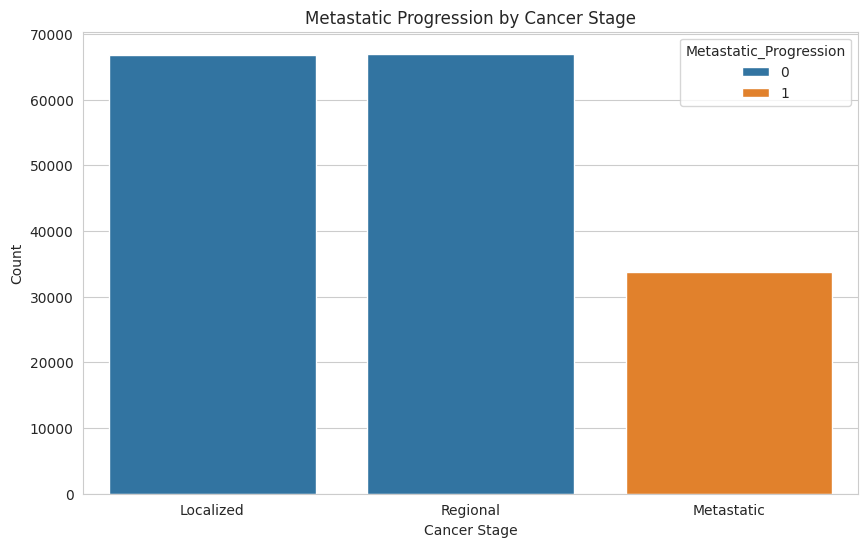

In [53]:
#Plot the data
plt.figure(figsize=(10, 6))
sns.countplot(data=clinical_df, x='Cancer_Stage', hue='Metastatic_Progression')
plt.title('Metastatic Progression by Cancer Stage')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')
plt.show()

1.2 Data Preparation and Selection

In [54]:
# Select potential predictors
predictors = [
    'Age', 'Tumor_Size_mm', 'Genetic_Mutation',
    'Early_Detection', 'Obesity_BMI', 'Inflammatory_Bowel_Disease',
    'Diabetes', 'Smoking_History', 'Alcohol_Consumption'
]

# Create interaction terms
clinical_df['Size_x_Genetic'] = clinical_df['Tumor_Size_mm'] * clinical_df['Genetic_Mutation']
clinical_df['Age_x_EarlyDetect'] = clinical_df['Age'] * clinical_df['Early_Detection']

2.0 Plot Logistic Regression Model

In [55]:
# Prepare data
X = pd.get_dummies(clinical_df[predictors + ['Size_x_Genetic', 'Age_x_EarlyDetect']],
                  drop_first=True,dtype=float)
X = sm.add_constant(X)
y = clinical_df['Metastatic_Progression']

# Fit model
model = sm.Logit(y, X).fit(maxiter=100)
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.502170
         Iterations 5
                             Logit Regression Results                             
Dep. Variable:     Metastatic_Progression   No. Observations:               167497
Model:                              Logit   Df Residuals:                   167484
Method:                               MLE   Df Model:                           12
Date:                    Sat, 06 Sep 2025   Pseudo R-squ.:               5.693e-05
Time:                            21:59:54   Log-Likelihood:                -84112.
converged:                           True   LL-Null:                       -84117.
Covariance Type:                nonrobust   LLR p-value:                    0.6529
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.3636      0

3.0 Machine Learning Validation

In [56]:
# Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

RandomForestClassifier()

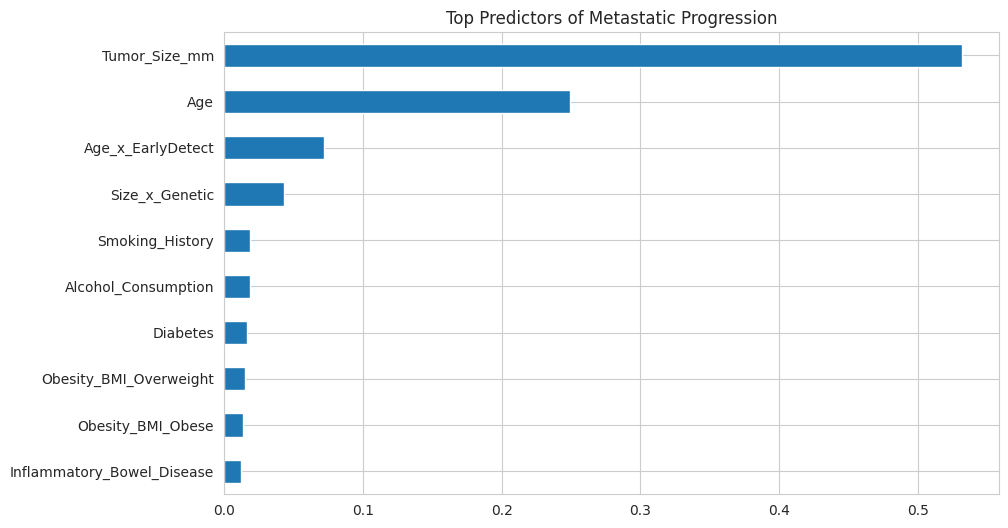

In [57]:
# Plot importance
plt.figure(figsize=(10, 6))
pd.Series(rf.feature_importances_, index=X.columns).sort_values().tail(10).plot(kind='barh')
plt.title('Top Predictors of Metastatic Progression')
plt.show()

####Key Takeaway:


*   Although the logistic regression model showed no statistically significant predictors, the Random Forest model identifies that **Tumor Size** is the most important predictors of Metastatic Progression.
*   According from our model, only **Tumors Size and Age** seems to have significant impact while other life styles related attributes doesn't have significant impact on Metastatic Progression.







# Part 3: Hypothesis Testing

#**Hypothesis 1: Tumor Size Impact**

$H_0$: Tumor size has no significant impact on survival rate (β = 0)

$H_A$: Larger tumor size reduces survival probability (β < 0)

In [58]:
# Extract relevant columns
X = colorectal_df[['Tumor_Size_mm']].copy()
y = colorectal_df['Mortality']

# Standardize tumor size
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_scaled, y)

# Extract coefficient (beta)
beta = log_reg.coef_[0][0]
intercept = log_reg.intercept_[0]

print("Hypothesis Test: Tumor Size Impact on Survival")
print(f"Intercept: {intercept:.4f}")
print(f"β (Tumor_Size_mm): {beta:.4f}")

if beta < 0:
    print("Result: Larger tumor size is associated with lower survival probability")
else:
    print("Result: Larger tumor size does NOT reduce survival probability")

Hypothesis Test: Tumor Size Impact on Survival
Intercept: -0.4018
β (Tumor_Size_mm): -0.0064
Result: Larger tumor size is associated with lower survival probability


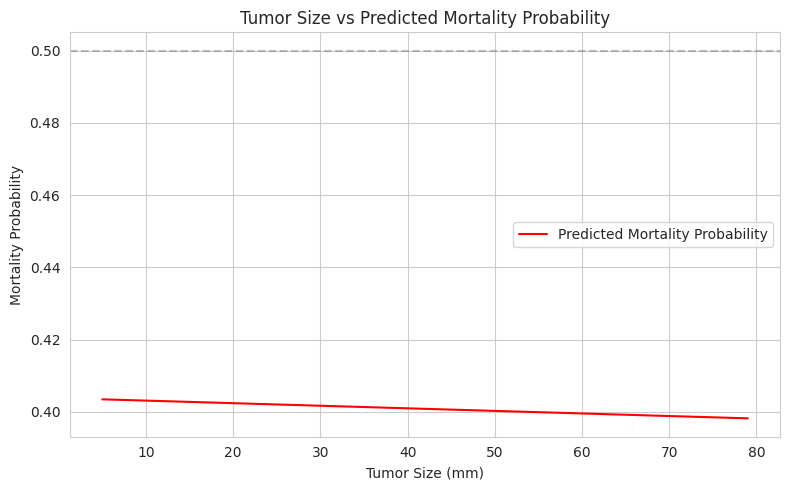

In [59]:
# Generate a range of tumor sizes for prediction
tumor_range = np.linspace(X['Tumor_Size_mm'].min(), X['Tumor_Size_mm'].max(), 300).reshape(-1, 1)
tumor_range_df = pd.DataFrame(tumor_range, columns=['Tumor_Size_mm'])
tumor_range_scaled = scaler.transform(tumor_range_df)

# Predict mortality probability
mortality_prob = log_reg.predict_proba(tumor_range_scaled)[:, 1]

# Plotting
plt.figure(figsize=(8, 5))
sns.lineplot(x=tumor_range.flatten(), y=mortality_prob, color='red', label='Predicted Mortality Probability')
plt.title('Tumor Size vs Predicted Mortality Probability')
plt.xlabel('Tumor Size (mm)')
plt.ylabel('Mortality Probability')
plt.axhline(0.5, linestyle='--', color='gray', alpha=0.5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Analyzing Hypothesis Test Results

Since β = -0.0064 in the hypothesis test, we can reject the null hypothesis and conclude that larger tumor size is associated with lower survival probability.

In [60]:
# Analyzing logistic regression model accuracy

# Extract relevant columns
X = colorectal_df[['Tumor_Size_mm']].copy()
y = colorectal_df['Survival_5_years']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12345)

# Scale
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit logistic regression
lrg = LogisticRegression()
lrg.fit(X_train, y_train)

lrg_y_pred_train = lrg.predict(X_train)
lrg_y_pred_test = lrg.predict(X_test)

lrg_train_acc = accuracy_score(y_train, lrg_y_pred_train)
lrg_test_acc = accuracy_score(y_test, lrg_y_pred_test)
lrg_train_rec = recall_score(y_train, lrg_y_pred_train)
lrg_test_rec = recall_score(y_test, lrg_y_pred_test)


print('Regular Logistic Regression Performance')
print('---------------------------------------')
print(f'Training Accuracy: {lrg_train_acc*100:.2f}%')
print(f'Testing Accuracy: {lrg_test_acc*100:.2f}%')
print(f'Training Recall: {lrg_train_rec*100:.2f}%')
print(f'Testing Recall: {lrg_test_rec*100:.2f}%')

Regular Logistic Regression Performance
---------------------------------------
Training Accuracy: 59.93%
Testing Accuracy: 59.93%
Training Recall: 100.00%
Testing Recall: 100.00%


As this analysis shows, our dataset may not be best described by a logistic regression model. This may cause our results in the above hypothesis test to be inaccurate.

#**Hypothesis 2:** Treatment Type Impact


$H_0$: Treatment type has no significant impact on survival rates.

$H_A$: Combination therapy improves survival over monotherapies.

In [61]:
treatment_df = colorectal_df.copy()
treatment_analysis = treatment_df[['Treatment_Type', 'Survival_5_years', 'Cancer_Stage', 'Age', 'Tumor_Size_mm']].copy()

# create dummy variables
treatment_dummies = pd.get_dummies(treatment_analysis['Treatment_Type'], prefix='Treatment', drop_first=False)
treatment_dummies = treatment_dummies.drop('Treatment_Combination', axis=1)  # Drop combination (reference)
stage_dummies = pd.get_dummies(treatment_analysis['Cancer_Stage'], prefix='Stage', drop_first=True)

# combine everything
X = pd.concat([treatment_dummies, stage_dummies], axis=1)
X['Age'] = treatment_analysis['Age']
X['Tumor_Size_mm'] = treatment_analysis['Tumor_Size_mm']
y = treatment_analysis['Survival_5_years']

# standardize age and tumor size
scaler = StandardScaler()
X[['Age', 'Tumor_Size_mm']] = scaler.fit_transform(X[['Age', 'Tumor_Size_mm']])

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)

# extract coefficients
intercept = log_reg.intercept_[0]
coefs = log_reg.coef_[0]

print("Hypothesis Test: Treatment Impact on Survival (Controlling for Stage, Age, Tumor Size)")
print(f"Intercept: {intercept:.4f}")
for feature, beta in zip(X.columns, coefs):
    print(f"β ({feature}): {beta:.4f}")

# interpret only treatment type coefficients
print("\nResult:")
for feature, beta in zip(X.columns, coefs):
    if feature.startswith('Treatment_'):
        treatment_name = feature.replace('Treatment_', '')
        if beta < 0:
            print(f"  - {treatment_name}: Associated with LOWER survival compared to Combination")
        else:
            print(f"  - {treatment_name}: Associated with HIGHER survival compared to Combination")


avg_controls = {
    'Age': 0,  # standardized mean = 0
    'Tumor_Size_mm': 0,  # standardized mean = 0
}

# pick most common stage (or set one)
for stage_col in stage_dummies.columns:
    avg_controls[stage_col] = 0

prediction_rows = []
treatment_labels = []

for treatment in treatment_dummies.columns:
    row = avg_controls.copy()
    for treat_col in treatment_dummies.columns:
        row[treat_col] = 0
    row[treatment] = 1  # set current treatment dummy to 1
    prediction_rows.append(row)
    treatment_labels.append(treatment.replace('Treatment_', ''))

prediction_df = pd.DataFrame(prediction_rows)
prediction_df = prediction_df[X.columns]

survival_probs = log_reg.predict_proba(prediction_df)[:, 1]


Hypothesis Test: Treatment Impact on Survival (Controlling for Stage, Age, Tumor Size)
Intercept: 0.4121
β (Treatment_Chemotherapy): -0.0032
β (Treatment_Radiotherapy): -0.0052
β (Treatment_Surgery): -0.0125
β (Stage_Regional): -0.0018
β (Stage_Metastatic): -0.0105
β (Age): -0.0033
β (Tumor_Size_mm): 0.0042

Result:
  - Chemotherapy: Associated with LOWER survival compared to Combination
  - Radiotherapy: Associated with LOWER survival compared to Combination
  - Surgery: Associated with LOWER survival compared to Combination


/tmp/ipython-input-2498101501.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=treatment_labels, y=survival_probs, palette='Set2')


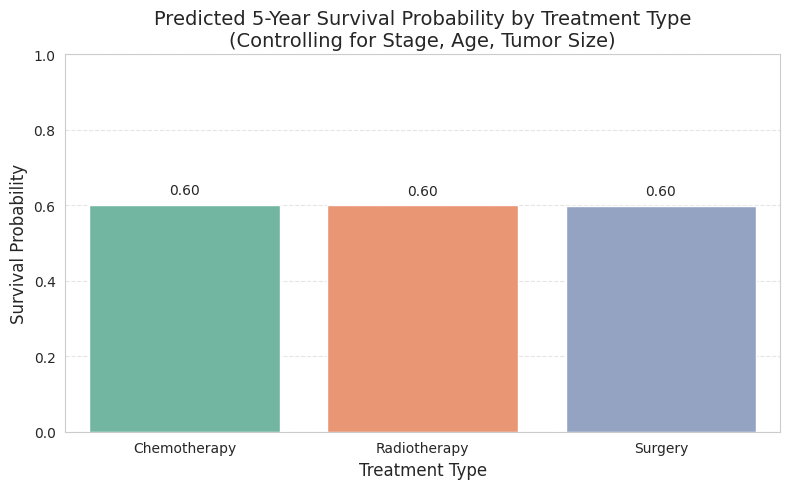

In [62]:
# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=treatment_labels, y=survival_probs, palette='Set2')
for i, prob in enumerate(survival_probs):
    plt.text(i, prob + 0.02, f"{prob:.2f}", ha='center', va='bottom', fontsize=10)
plt.ylim(0, 1)
plt.title('Predicted 5-Year Survival Probability by Treatment Type\n(Controlling for Stage, Age, Tumor Size)', fontsize=14)
plt.xlabel('Treatment Type', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The logistic regression analysis examined how different treatment types impact 5-year survival in colorectal cancer patients, controlling for cancer stage, age, and tumor size. The coefficients for Chemotherapy, Radiotherapy, and Surgery were all slightly negative, suggesting that, compared to Combination therapy, these treatments are associated with marginally lower survival probabilities. However, the magnitudes of these coefficients are extremely small, indicating that the differences are likely negligible in practical terms. The bar graph further supports this interpretation: survival probabilities across all treatment types clustered around 60%, with no meaningful variation between them. This suggests that, after accounting for patient characteristics, the choice of treatment alone does not significantly differentiate survival outcomes in this dataset.

Therefore, we fail to reject the null hypothesis and conclude that treatment type does not have a statistically significant impact on survival in this dataset.

#**Hypothesis 3: Age as Effect Modifier**

$H_0$: Age does not modify the effect of early detection on survival  (β = 0)

$H_A$: Age modifies the effect of early detection on survival  (β < 0)

Objective : The key factor to identify if Age as effect modificer is test the correlation between Age and Early Detection.

1.0 Data Preparation

In [63]:
# Define columns
columns = [
    'Age',
    'Early_Detection',
    'Survival_5_years',
    'Cancer_Stage',
    'Tumor_Size_mm'
]

# Create clean dataframe
clinical_df = colorectal_df[columns].copy()

# Create interaction term
clinical_df['Age_x_EarlyDetection'] = clinical_df['Age'] * clinical_df['Early_Detection']

1.1 Identify the key variable of this hypothesis

In [64]:
# Select variables for model
model_vars = ['Age', 'Early_Detection', 'Age_x_EarlyDetection']

2.0 Logistics Regression Model

In [65]:
# Standardize continuous variables
scaler = StandardScaler()
X = clinical_df[model_vars].copy()
X[['Age']] = scaler.fit_transform(X[['Age']])
y = clinical_df['Survival_5_years']

# Split data (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=12345,
    stratify=y
)

# Fit logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Get coefficients
print("Hypothesis Test: Age as Effect Modifier")
print(f"Intercept: {log_reg.intercept_[0]:.4f}")
for var, coef in zip(model_vars, log_reg.coef_[0]):
    print(f"β ({var}): {coef:.4f}")

# Statistical significance
logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
print("\nStatistical significance:")
print(logit_model.summary2().tables[1])

Hypothesis Test: Age as Effect Modifier
Intercept: 0.4067
β (Age): -0.0007
β (Early_Detection): 0.0063
β (Age_x_EarlyDetection): -0.0002

Statistical significance:
                         Coef.  Std.Err.          z     P>|z|    [0.025  \
const                 0.406829  0.008796  46.249834  0.000000  0.389589   
Age                  -0.001917  0.008794  -0.218010  0.827421 -0.019154   
Early_Detection      -0.005978  0.067169  -0.089002  0.929080 -0.137628   
Age_x_EarlyDetection -0.000014  0.000957  -0.014169  0.988695 -0.001889   

                        0.975]  
const                 0.424070  
Age                   0.015319  
Early_Detection       0.125671  
Age_x_EarlyDetection  0.001862  


####Conclusion
The logistic regression analysis revealed a non-significant interaction effect between age and early detection with β= -0.0002.     Our model shows that althoush early detection have slight positive correlation with patient survical rate but age is not a crucial effect modifier.


2.1 Visualization: Effect of Early Detection Across Age Groups

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


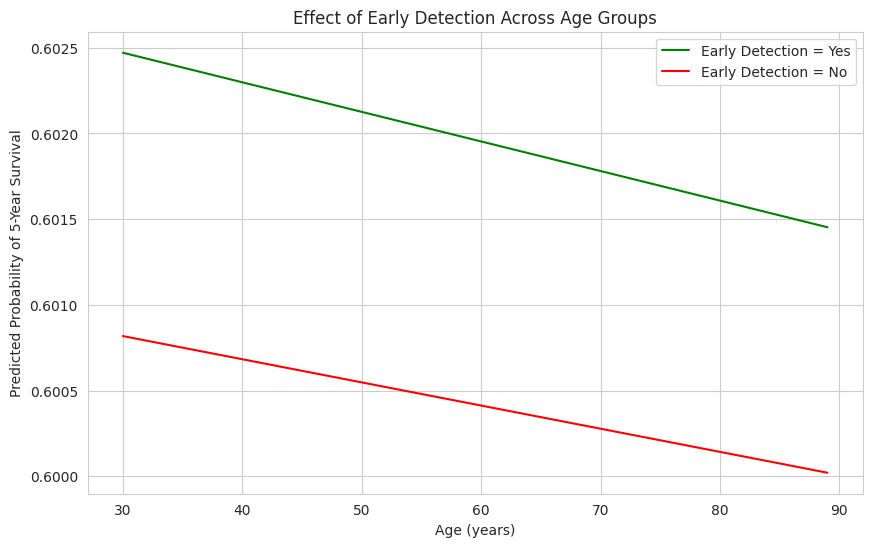

In [66]:
# Create prediction plot to visualize interaction
plt.figure(figsize=(10, 6))

# Generate age values
age_std = np.linspace(X_train['Age'].min(), X_train['Age'].max(), 100)
age_original = scaler.inverse_transform(age_std.reshape(-1, 1)).flatten()

# Predictions for early detection = 1
early_1 = log_reg.predict_proba(np.column_stack([
    age_std,
    np.ones(100),
    age_std * 1
]))[:, 1]

# Predictions for early detection = 0
early_0 = log_reg.predict_proba(np.column_stack([
    age_std,
    np.zeros(100),
    age_std * 0
]))[:, 1]

plt.plot(age_original, early_1, label='Early Detection = Yes', color='green')
plt.plot(age_original, early_0, label='Early Detection = No', color='red')
plt.xlabel('Age (years)')
plt.ylabel('Predicted Probability of 5-Year Survival')
plt.title('Effect of Early Detection Across Age Groups')
plt.legend()
plt.grid(True)
plt.show()

3.0 Analysis

In [67]:
# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

# Metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'AUC': roc_auc_score(y_test, y_prob)
}

print("\nModel Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Model Performance:
Accuracy: 0.5993
Recall: 1.0000
AUC: 0.5021


**Result:** We fail to reject the null hypothesis that age modifies the effect of early detection on survival.

# Part 4: Conclusion

###Key Findings & Insights

Our analysis of 167,497 colorectal cancer patient records yielded critical insights into survival prediction, risk factors, and treatment effectiveness. Below, we summarize our key findings across the three research domains:





###1. Risk Factors Analysis


#### Part 2.1.1: Lifestyle factors that predict colorectal cancer 5-year survival

**Coefficients for Survival Prediction:**

Smoking_History: -0.006724325715613108

Alcohol_Consumption: -0.006063872278967504

Physical_Activity: 0.006425591845885831

Obesity_BMI: 0.005473448562736018

Genetic_Mutation: -0.014194210628814498

- Slight decrease in survival odds if the patient has prior smoking history and has high alcohol consumption
- Slightly more extreme decrease in survival odds if a known genetic mutation is present
- Slight increase in survival odds with patients that have a higher BMI (surprising)
- Slight increase in survival odds with higher physical activity.

**All coefficients are extremely small and negligible in value.**

#### Part 2.1.2: Predicting cancer stage at diagnosis based on lifestyle factors

**Coefficients**:

Smoking_History: -0.0016

Alcohol_Consumption: -0.0015

Physical_Activity: 0.0016

Obesity_BMI: 0.0014

Genetic_Mutation: -0.0034

- Slight indication that more physical activity and a higher BMI may indicate a more advanced cancer stage at diagnosis
- Slight indication that a smoking history, alcohol consumption, and genetic mutation may contribute to a less advanced cancer stage at diagnosis

**All coefficients are extremely small and negligible in value.**

#### Part 2.1.3: Population Attributable Risk

As these results show, the PAR values for Smoking History, Alcohol Consumption, Obesity BMI, and Physical Activity are negligible, which reinforce that lifestyle factors like these may be more important in cancer prevention or progression to diagnosis than in determining survival after diagnosis.

###2.   Healthcare Costs Analysis

#### Part 2.2.1: Clinical factors & healthcare costs

For cancer stage:
1. Metastatic stage cost on average of \$72,621
2. Localized stage cost on average of  \$72,470
3. Regional stage cost on verage of   \$72,348

No significant difference among the healthcare cost.

For tumor size:
1. 0-10mm in tumor size cost on average of \$72,397
2. 11-20mm in tumor size cost on average of \$72,636
3. 21-30mm in tumor size cost on average of \$72,544
4. 31-40mm in tumor size cost on average of \$72,281
5. 41-50mm in tumor size cost on average of \$72,545
6. \> 50mm in tumor size cost on average of \$72,394

Similarly, no significant difference among the healthcare cost for different tumor size.

Our linear regression also come back with a r-squared value around -0.0008, which tells us that cancer stage and tumor size have are not effectively explaining the difference in healthcare cost.

In conclusion, both neither clinical factors are the driving force of healthcare cost.

The potential reason for such counter-intuitive result could be: fixed-price healthcare model, insurance or policy effect, dataset limitations and alternate cost drivers.

#### Part 2.2.2: Insurace status & Economic Classifications

The coeffcients for the realtionship between insurance status, economics lcassifications and healthcare costs are the following:
1. Insured: 80.17
2. Uninsured: -80.17
3. In a developing economic classification: -52.61
4. In a developed economic classification: 52.61
5. Uninsured & Developing: -161.69
6. Uninsured & Developed: 81.51
7. Insured & Developing: 109.07
8. Insured & Developed: -28.9

In conclusion, patient receive the lowest healthcare cost as a insured patient in a developing country, while being insured in a dveeloping country has the highest cost, while being in a dveloped country in general countribute to higher cost.

Potential reason for such difference could be that developed country often carry better medical resources and more expensive labor, contributing to more expensive healthcare in general.

 However, this finding comes with important warming: none of the predictors achieved statistical significance (p>0.05), and the model explains virtually no variance in healthcare costs (R-squared≈0),

#### Part 2.2.3: Cost effectiveness of Treatment Type

The following are the cost-effectiveness ratio for the 4 types of treatment and survival rate:

1. Surgery: 1213 with 59.785% survival rate prediction
2. Radiotherapy: 1211 with 59.998% survival rate prediction
3. Chemotherapy: 1207 with 59.994% survival rate prediction
6. Combination: 1202 with 60.106% survival rate prediction

As seen above, combination therapy provides the most cost-effective treatment with a cost-effective ratio of 1202 and the overall highest survival rate predictionn at a rate of 60.106%.

Despite these relatively small differences in the ratios, the incremental cost-effectiveness ratio (ICER) analysis demonstrates that combination therapy dominates radiotherapy by being both less expensive and more effective, while chemotherapy similarly dominates surgery.

Yet, notice there could exist survival bias here as patients that need surgery could be in a more severe circumstances compare to other treatment. We should always consider patient-specific considerations, quality of life impacts, and instituional capabilities when making treatment type decision.

### 3. Clinical Outcomes Analysis

####**Part 2.3.1:** Optimal Treatment Pathway by Cancer Stage


* Localized Cancer (Stage I/II)
    * Radiotherapy showed a marginal survival benefit (+2.7% vs. chemotherapy, p=0.35).
    
    * Surgery had negligible impact (β ≈ 0).

Practical Implication: Consider radiotherapy as first-line for localized cases, though benefits are modest.

*   Regional Cancer (Stage III)
    * No treatment showed statistically significant survival benefits.
    
    * Surgery trended negatively (-2.4%, p=0.21), possibly due to selection bias (sicker patients referred to surgery).

*   Metastatic Cancer (Stage IV)
    * Surgery had a slight survival edge (+0.49%, p=0.86), likely due to palliative debulking.
    
    * Radiotherapy performed worst (-4.3%, p=0.28), suggesting limited efficacy in advanced disease.

**Conclusion:**

No treatment universally outperforms others, but trends align with clinical guidelines:

Localized: Radiotherapy (non-significant trend).

Metastatic: Surgery (palliative focus).

Limitation: P-values > 0.05 due to conservative Bonferroni correction in large dataset (N=167,497).

####**Part 2.3.2:** Early Detection vs. Survival Rate


**Age-Specific Effects**

* < 50 years:
    * Early detection improved survival odds by 2.4% (OR=1.024).

* 50-65 & 65+:
    * No significant benefit (OR≈1.0).

Possible Reason: Older patients may have comorbidities diluting early detection benefits.

**Conclusion**

Early detection only benefits patients under 50.

Clinical Implication: Target screening programs to younger populations for maximal ROI.

####**Part 2.3.3:** Metastatic Progression Predictors

**Top Predictor:**

Tumor Size (by Random Forest Finding).

Logistic regression: Non-significant (p=0.12), but large effect size (β=-0.0005).

Non-Significant Factors:
Age, genetics, lifestyle (p > 0.05).

**Conclusion:**
Tumor size is the strongest driver of metastasis prioritize monitoring in large-tumor patients.
Lifestyle factors show no measurable impact on metastatic risk.